In [ ]:
#loading required packages for notebook
library(data.table)
library(lubridate)
library(dplyr)
library(bigrquery)
install.packages("nortest")
library(nortest)
library(ggplot2)
library(tidyr)
library(broom)
install.packages("forestploter")
library(forestploter)
install.packages("UpSetR")
library(UpSetR)
library(magrittr)
install.packages("survival")
library("survival")

# Dataset Setup

In [1]:
#loading data 
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/BioVU_MTP_Project_Full_Dataset_MTP_April24.csv .")
data<-fread("BioVU_MTP_Project_Full_Dataset_MTP_April24.csv")
head(data)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
R268958458,TP53,chr17,7674227,7674227,T,C,nonsynonymous SNV,10/25/1940,7493-AB-357,7493-AB-850,1/13/2014,2/19/2017,0.023,0.011
R268958458,ASXL1,chr20,32435899,32435899,C,T,stopgain,10/25/1940,7493-AB-357,7493-AB-850,1/13/2014,2/19/2017,0.004,0.058
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,9/9/1953,7493-AB-092,7493-AB-967,3/30/2009,12/24/2017,0.001,0.033
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,8/16/1934,9700-AB-3966,9700-AB-0011,2/21/2012,2/26/2017,0.023,0.007
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,10/7/1927,9700-AB-5035,9700-AB-4476,3/16/2011,3/28/2015,0.271,0.348
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,9/19/1930,9700-AB-0782,9700-AB-1956,10/20/2012,12/11/2014,0.097,0.090


In [2]:
#adding in age at timepoints
data$DOB <-as.Date(mdy(data$DOB))
data$DATE_A <-as.Date(mdy(data$DATE_A))
data$DATE_B <-as.Date(mdy(data$DATE_B))

data$Age_A <- as.numeric(interval(data$DOB, data$DATE_A) %/% years(1))
data$Age_B <- as.numeric(interval(data$DOB, data$DATE_B) %/% years(1))

head(data)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
R268958458,TP53,chr17,7674227,7674227,T,C,nonsynonymous SNV,1940-10-25,7493-AB-357,7493-AB-850,2014-01-13,2017-02-19,0.023,0.011,73,76
R268958458,ASXL1,chr20,32435899,32435899,C,T,stopgain,1940-10-25,7493-AB-357,7493-AB-850,2014-01-13,2017-02-19,0.004,0.058,73,76
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,7493-AB-967,2009-03-30,2017-12-24,0.001,0.033,55,64
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,9700-AB-0011,2012-02-21,2017-02-26,0.023,0.007,77,82
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,9700-AB-4476,2011-03-16,2015-03-28,0.271,0.348,83,87
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,9700-AB-1956,2012-10-20,2014-12-11,0.097,0.090,82,84


In [3]:
#calculating AF difference  
data$AF_Diff <-data$AF_B - data$AF_A

#calculating time between timepoints, subsetting to only individuals with at least 6 months between timepoints (no one eliminated)
data$Date_Diff_Years <- round(as.numeric(difftime(data$DATE_B, data$DATE_A, units = "days")) / 365.25, 1)
data<-subset(data, Date_Diff_Years>=0.5)

#calculating growth rate 
data$Growth_Rate <-(data$AF_B/data$AF_A)^(1/(data$Date_Diff_Years))-1

# #adding a column for the clone behavior 
data$abs <-abs(data$Growth_Rate)
quants<-quantile(data$abs, probs = c(0.10))
data$direction <-"expansion"
data$direction[data$AF_Diff<=0] <-"reduction"
data$direction[data$abs <=quants] <-"stagnant"
data<-data[,-c("abs")]
head(data)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<chr>,⋯,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
R268958458,TP53,chr17,7674227,7674227,T,C,nonsynonymous SNV,1940-10-25,7493-AB-357,⋯,2014-01-13,2017-02-19,0.023,0.011,73,76,-0.012,3.1,-0.21174619,reduction
R268958458,ASXL1,chr20,32435899,32435899,C,T,stopgain,1940-10-25,7493-AB-357,⋯,2014-01-13,2017-02-19,0.004,0.058,73,76,0.054,3.1,1.36938066,expansion
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,2009-03-30,2017-12-24,0.001,0.033,55,64,0.032,8.7,0.49465800,expansion
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,2012-02-21,2017-02-26,0.023,0.007,77,82,-0.016,5.0,-0.21173174,reduction
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,2011-03-16,2015-03-28,0.271,0.348,83,87,0.077,4.0,0.06451672,expansion
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,2012-10-20,2014-12-11,0.097,0.090,82,84,-0.007,2.1,-0.03503871,reduction


In [4]:
#getting person_id for these individuals for BioVU
system("gsutil cp gs://bicklab-main-storage/Data/BioVU/BioVU_GRID_to_personid_conversion.txt .")
grid_conversions <-fread("BioVU_GRID_to_personid_conversion.txt")

individuals <-merge(data, grid_conversions, by="GRID")
individuals <-distinct(individuals, person_id, .keep_all = TRUE)
head(individuals)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,person_id
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<chr>,⋯,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,2017-12-24,0.001,0.033,55,64,0.032,8.7,0.49465800,expansion,2240791
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,2017-02-26,0.023,0.007,77,82,-0.016,5.0,-0.21173174,reduction,1715111
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,2015-03-28,0.271,0.348,83,87,0.077,4.0,0.06451672,expansion,1589089
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,2014-12-11,0.097,0.090,82,84,-0.007,2.1,-0.03503871,reduction,189378
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,2016-11-05,0.024,0.003,64,72,-0.021,8.2,-0.22399043,reduction,2584564
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,2018-03-20,0.020,0.028,66,69,0.008,3.5,0.10090759,expansion,1533282


In [5]:
#pulling all the codes for the individuals

id_string <- paste(individuals$person_id, collapse = ", ")

sql <- paste0("
  SELECT *
  FROM `sd-vumc-tanagra-test.terra_sd_20230831.person`
  WHERE person_id IN (", id_string, ")
")

projectid <- "sd-vumc-tanagra-test"
demo <- bq_project_query(projectid, sql)
demo <- bq_table_download(demo)
demo<-demo[,c("person_source_value", "gender_source_value", "race_source_value")]
colnames(demo)<-c("GRID", "Sex", "Race")
head(demo)

GRID,Sex,Race
<chr>,<chr>,<chr>
R285910300,F,W
R272133437,F,W
R208876101,F,W
R275256163,F,B
R259494883,F,W
R284910087,F,B


In [6]:
data<-merge(data, demo, by="GRID")

In [7]:
#data about clonal categories 
table(data$direction)
quants

#data about number of individuals and clones
nrow(data)
length(unique(data$GRID))



expansion reduction  stagnant 
      612       190        90 

10% 
0.01413474

[1] 892

[1] 711

In [8]:
#data about age distributions
mean(data$Age_A)
min(data$Age_A)
max(data$Age_A)

mean(data$Age_B)
min(data$Age_B)
max(data$Age_B)

[1] 70.25

[1] 19

[1] 96

[1] 75.96413

[1] 26

[1] 99

In [9]:
#data about time between timepoints 
mean(data$Date_Diff_Years)
sd(data$Date_Diff_Years)
min(data$Date_Diff_Years)
max(data$Date_Diff_Years)

[1] 5.706278

[1] 2.582403

[1] 0.7

[1] 13.4

In [10]:
mean(data$AF_A)
mean(data$AF_B)

[1] 0.0679787

[1] 0.0950583

In [1]:
write.table(data, "MTP_Dataset_May24.txt", sep="\t", row.names=F, col.names=T, quote=F)
system("gsutil cp MTP_Dataset_May24.txt gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/")
data_unique <- distinct(data, GRID, .keep_all = TRUE)
write.table(data_unique, "MTP_Dataset_May24_by_individual.txt", sep="\t", row.names=F, col.names=T, quote=F)
system("gsutil cp MTP_Dataset_May24_by_individual.txt gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/")

# Figure 1- Descriptive Figures 

In [1]:
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/MTP_Dataset_May24.txt .")
data<-fread("MTP_Dataset_May24.txt")
head(data)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,0.001,0.033,55,64,0.032,8.7,0.49465800,expansion,M,W
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,0.023,0.007,77,82,-0.016,5.0,-0.21173174,reduction,F,W
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,0.271,0.348,83,87,0.077,4.0,0.06451672,expansion,M,W
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,0.097,0.090,82,84,-0.007,2.1,-0.03503871,reduction,M,W
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,0.024,0.003,64,72,-0.021,8.2,-0.22399043,reduction,M,W
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,0.020,0.028,66,69,0.008,3.5,0.10090759,expansion,F,W


In [5]:
#checking number of people that have VAF>0.02 at only one timepoint
data_vaf_a <-subset(data, AF_A<0.02)
data_vaf_b <-subset(data, AF_B<0.02)
length(unique(data_vaf_a$GRID))
length(unique(data_vaf_b$GRID))

[1] 144

[1] 40

In [8]:
#checking if vaf is significantly different by driver gene at timepoint A 

#texting if the data is normally distributed - it is not 
ad.test(data$AF_A)

#performing non-parametric test 
# Kruskal-Wallis Test
kruskal.test(AF_A ~ Gene, data = data)


	Anderson-Darling normality test

data:  data$AF_A
A = 87.641, p-value < 2.2e-16



	Kruskal-Wallis rank sum test

data:  AF_A by Gene
Kruskal-Wallis chi-squared = 16.39, df = 15, p-value = 0.3566



	Kruskal-Wallis rank sum test

data:  AF_B by Gene
Kruskal-Wallis chi-squared = 30.614, df = 15, p-value = 0.009891


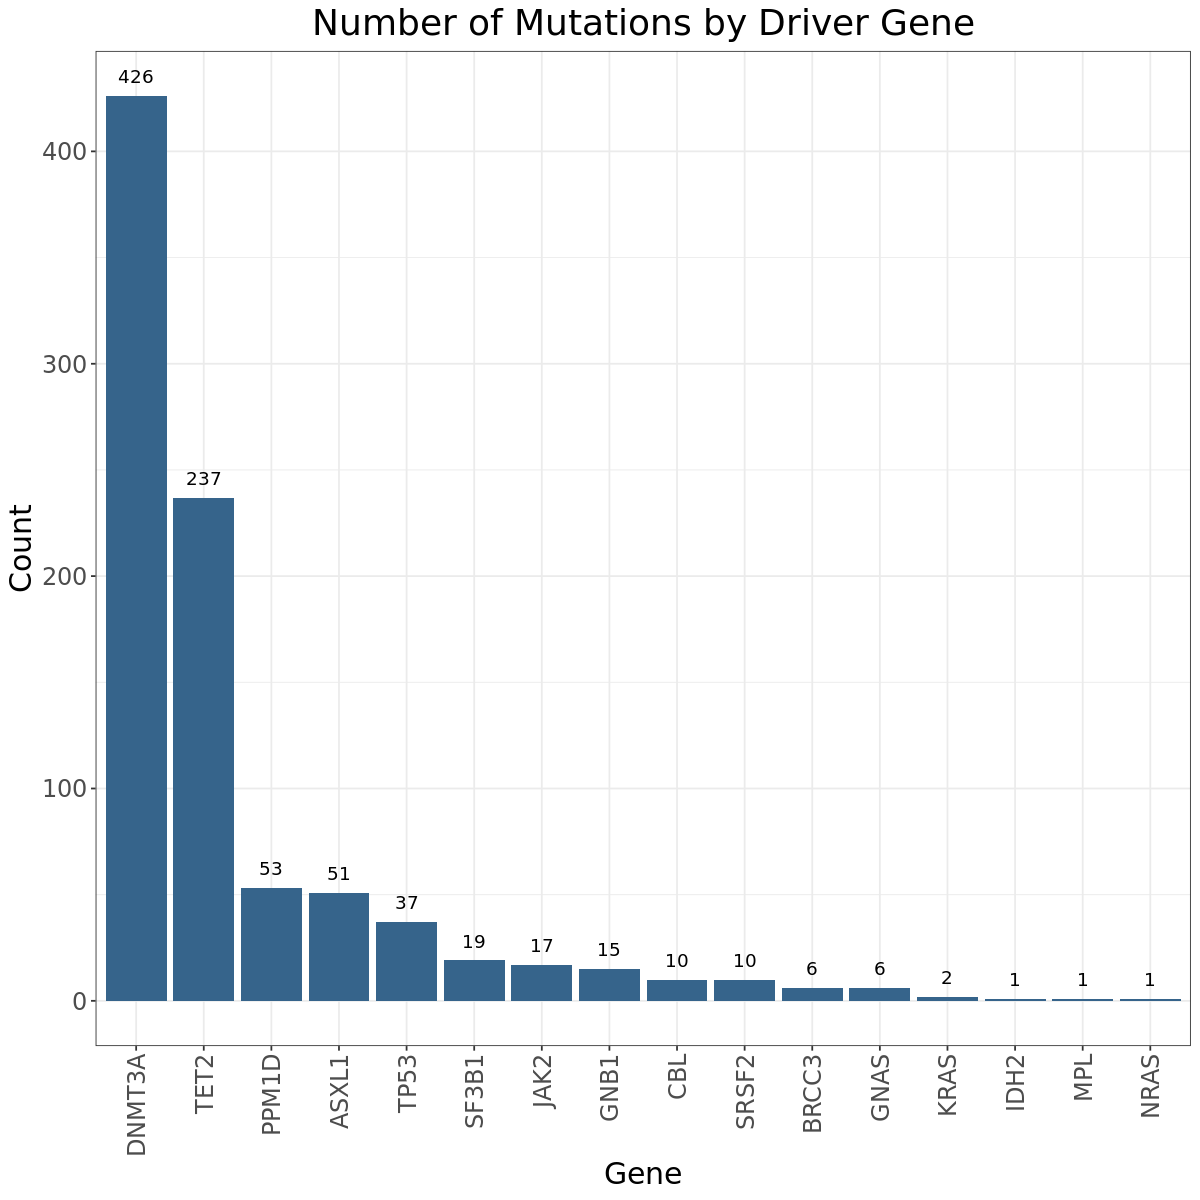

In [44]:
#number of mutations per gene
options(repr.plot.width=10, repr.plot.height=10)
g <- ggplot(data, aes(x=reorder(Gene,-table(Gene)[Gene])))
p<-g + geom_bar(aes(), fill="steelblue4")+geom_text(stat='count', aes(label=..count..), vjust=-1) + theme_bw()+ labs(x="Gene", y="Count", title="Number of Mutations by Driver Gene") +theme(plot.title = element_text(hjust = 0.5))+ theme(text = element_text(size = 18))+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p
ggsave(p, filename = "driver_gene_count.pdf",height = 7, width = 7)
system("gsutil cp driver_gene_count.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


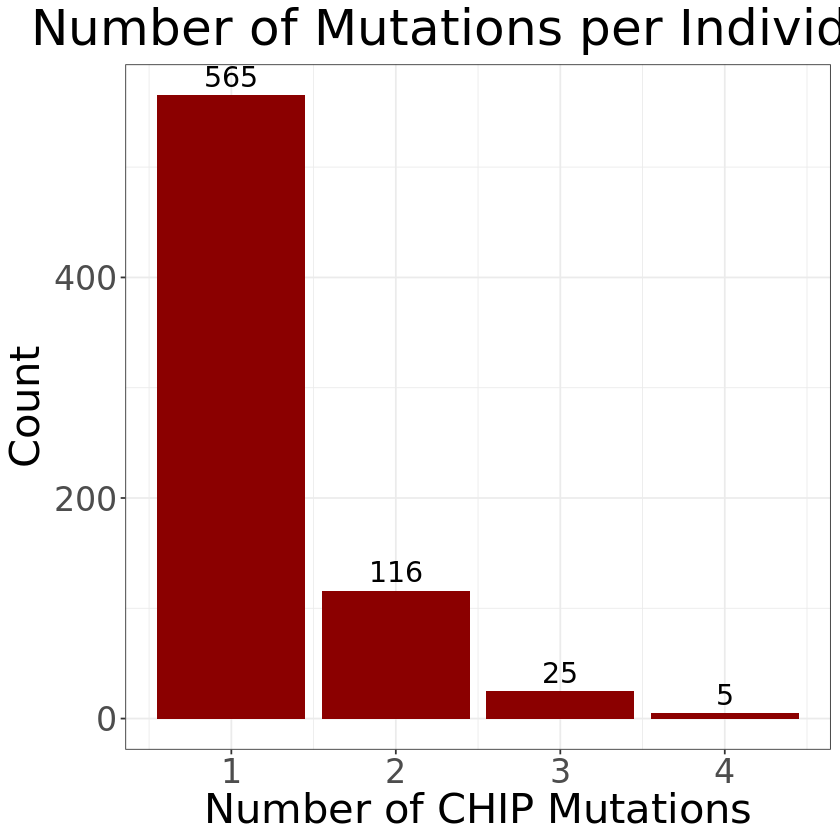

In [2]:
#number of mutations per individual 
options(repr.plot.width=7, repr.plot.height=7)
data<-data %>%
  add_count(GRID, name = 'mutations')
data_unique <-data[!duplicated(data$GRID)]
g <- ggplot(data_unique, aes(x=mutations))
p<-g + geom_bar(fill="darkred")+geom_text(stat='count', aes(label=..count..), size=6, vjust=-0.4) + theme_bw()+ labs(x="Number of CHIP Mutations", y="Count", title="Number of Mutations per Individual") +theme(plot.title = element_text(hjust = 0.5))+ theme(text = element_text(size = 25))
p
ggsave(p, filename = "mutation_count.pdf",height = 7, width = 7)
system("gsutil cp mutation_count.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Removed 35 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


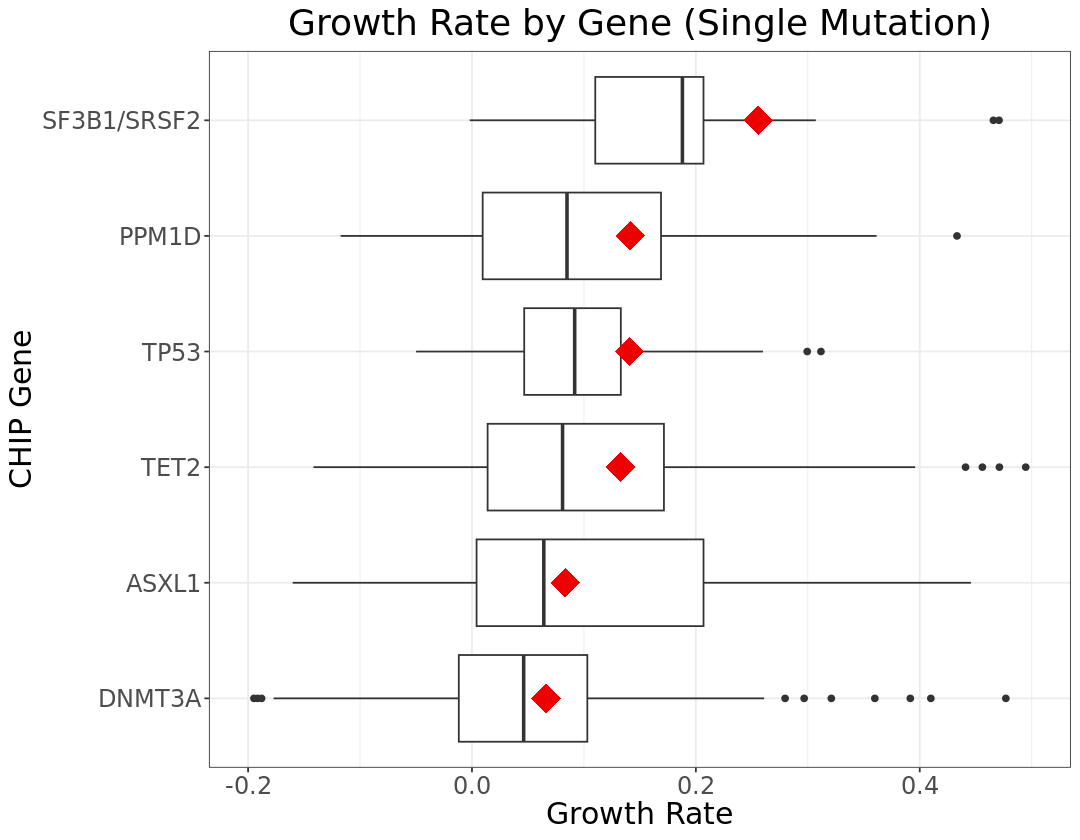

In [3]:
options(repr.plot.width=9, repr.plot.height=7)
#average growth rate by gene (one mutation)

data_subset<-subset(data, Gene=="ASXL1"| Gene=="DNMT3A"|Gene=="PPM1D"|Gene=="SF3B1"|Gene=="SRSF2"|Gene=="TET2"|Gene=="TP53")
data_subset$Gene[data_subset$Gene=="SRSF2"|data_subset$Gene=="SF3B1"]<-"SF3B1/SRSF2"
data_one <-subset(data_subset, mutations==1)

# Calculate the average growth rate for each gene
gene_avg_growth <- data_one %>%
  group_by(Gene) %>%
  summarize(avg_growth = mean(Growth_Rate))

# Reorder the levels of the Gene variable based on average growth rate (fastest to slowest)
gene_order <- gene_avg_growth$Gene[order(gene_avg_growth$avg_growth, decreasing = FALSE)]
data_one$Gene <- factor(data_one$Gene, levels = gene_order)

# Plot with reordered Gene variable
ggplot(data_one, aes(x = Growth_Rate, y = Gene)) + 
  geom_boxplot() + 
  stat_summary(data = gene_avg_growth, aes(x = avg_growth, y = Gene), 
               fun.y = mean, geom = "point", 
               shape = 18, size = 8, color = "red2", fill = "red2", 
               position = position_dodge(width = 0.75)) +
  scale_color_manual(values = c("darkred", "darkblue")) +
  theme_bw() +
  labs(color = "Type", x = "Growth Rate", y = "CHIP Gene", title = "Growth Rate by Gene (Single Mutation)") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 18))+ xlim(-0.2, 0.5)

In [16]:
#mean growth rate values 
data_one <-subset(data, mutations==1)
data_one$Gene[data_one$Gene=="SRSF2"|data_one$Gene=="SF3B1"]<-"SF3B1/SRSF2"

mean_growth_rate_by_gene <- data_one %>%
  group_by(Gene) %>%
  summarize(mean_growth_rate = mean(Growth_Rate))
mean_growth_rate_by_gene

Gene,mean_growth_rate
<chr>,<dbl>
ASXL1,0.08330504
BRCC3,-0.01499259
CBL,0.08400814
DNMT3A,0.06629699
GNAS,-0.03993570
GNB1,0.14295698
IDH2,0.18515555
JAK2,1.58055086
KRAS,-0.22978322


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


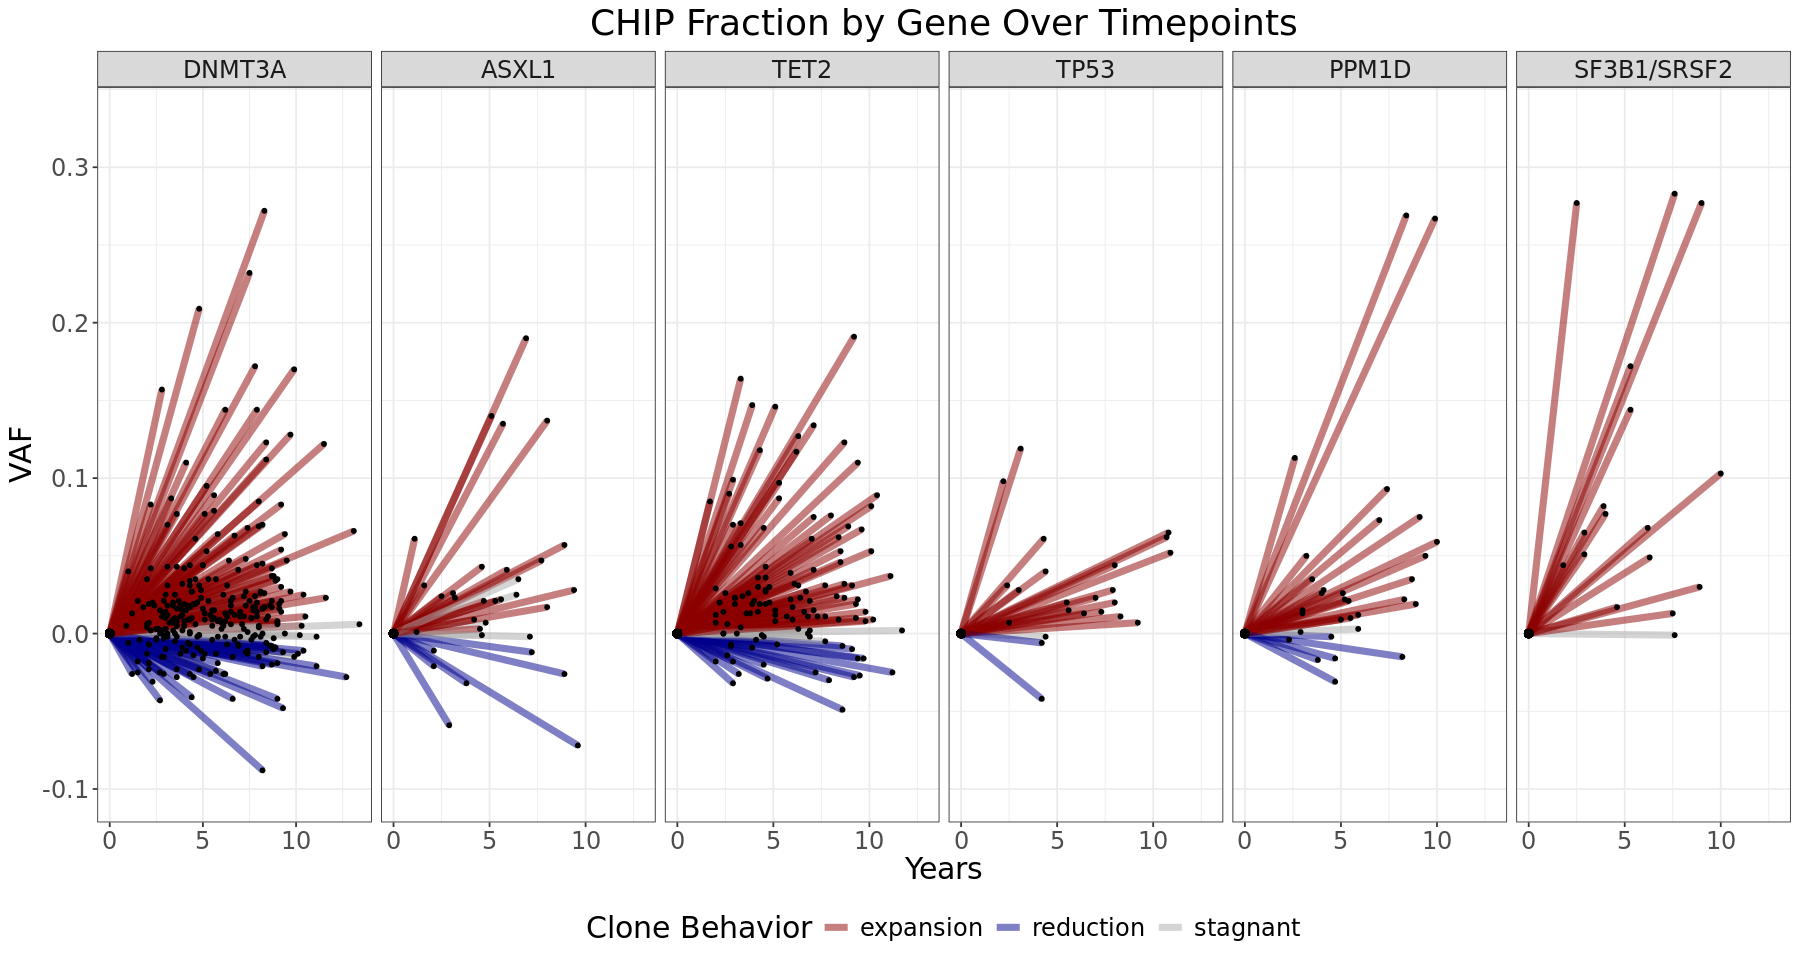

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
#clone behavior over time (1+ mutations)
data_one$initial <-"0"
data_one$AF_Diff <-as.numeric(data_one$AF_Diff)
data_one$initial <-as.numeric(data_one$initial)
data_one$Date_Diff_Years <-as.numeric(data_one$Date_Diff_Years)

p<-ggplot(data_one) + 
  geom_segment(aes(y = initial, yend = AF_Diff, x=initial, xend = Date_Diff_Years, color=direction), size=2, alpha=0.5)+
 geom_point(aes(x=initial,y = initial), size=2)+ 
  geom_point(aes(x=Date_Diff_Years,y = AF_Diff), size=1)+ facet_grid(.~Gene, scales="free_x")+theme_bw()+ labs(color = "Clone Behavior", x="Years", y="VAF", title="CHIP Fraction by Gene Over Timepoints") +theme(plot.title = element_text(hjust = 0.5))+theme(axis.text.x =element_text())+expand_limits(x = 13)+scale_color_manual(values=c("darkred","darkblue","darkgrey"))+ theme(text = element_text(size = 18))+ theme(legend.position = "bottom")+ ylim(-0.1, 0.33)

p

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.


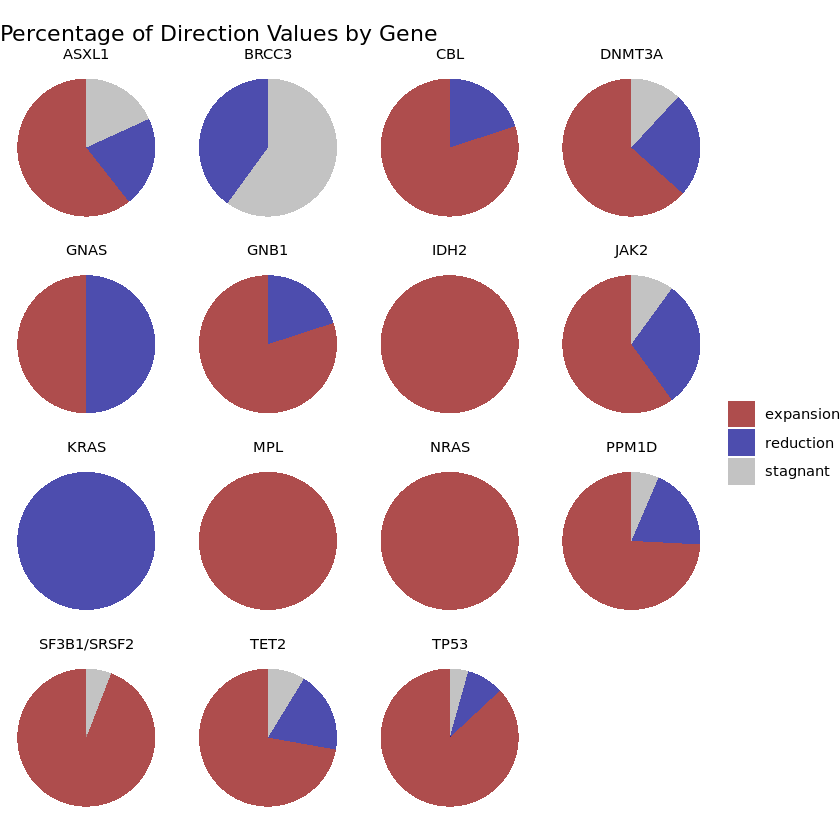

In [17]:
# Calculate the percentage of different values in the "direction" column grouped by "Gene"
direction_percentage <- data_one %>%
  group_by(Gene, direction) %>%
  summarise(count = n()) %>%
  mutate(percentage = count / sum(count) * 100)

# Plot pie chart
ggplot(direction_percentage, aes(x = "", y = percentage, fill = direction)) +
  geom_bar(stat = "identity", width = 1, alpha=0.7) +
  coord_polar("y", start = 0) +
  facet_wrap(~ Gene) +
  theme_void() +
  theme(legend.position = "right", legend.title = element_blank()) +
  labs(title = "Percentage of Direction Values by Gene")+scale_fill_manual(values=c("darkred", "darkblue", "darkgrey"))

In [22]:
#rate of reduction  
data_red <-subset(data_one, direction=="reduction")
data_red$Gene[data_one$red=="SRSF2"|data_red$Gene=="SF3B1"]<-"SF3B1/SRSF2"

mean_growth_rate_by_gene <- data_red %>%
  group_by(Gene) %>%
  summarize(mean_growth_rate = mean(Growth_Rate))
mean_growth_rate_by_gene

Gene,mean_growth_rate
<chr>,<dbl>
ASXL1,-0.16038640
BRCC3,-0.04622203
CBL,-0.21929082
DNMT3A,-0.09352449
GNAS,-0.17083447
GNB1,-0.03495178
JAK2,-0.25734222
KRAS,-0.22978322
PPM1D,-0.04369872


In [ ]:
library(ggplot2)

data$age_cat <-"<55"
data$age_cat[data$Age_A>=55 & data$Age_A<60] <-"55-59"
data$age_cat[data$Age_A>=60 & data$Age_A<65] <-"60-64"
data$age_cat[data$Age_A>=65 & data$Age_A<70] <-"65-69"
data$age_cat[data$Age_A>=70 & data$Age_A<75] <-"70-74"
data$age_cat[data$Age_A>=75 & data$Age_A<80] <-"75-79"
data$age_cat[data$Age_A>80] <-">=80"

options(repr.plot.width=9, repr.plot.height=9)
data_isolated <-subset.data.frame(data, Gene=="DNMT3A" | Gene=="TET2")
counts <-as.data.frame(table(data_isolated$age_cat))
colnames(counts)[1]<-c("age_cat")
counts$Freq <- sub("^", "n=", counts$Freq )
merged<-merge(data_isolated, counts, by="age_cat")
merged$Freq <- factor(merged$Freq, levels=c("n=40", "n=34", "n=98","n=163","n=136","n=112","n=80"))

h<-ggplot(merged,aes(x=age_cat))+geom_bar(aes(fill=Gene), position="dodge")+theme_bw()+ labs(fill = "Driver Gene", x="Age", y="Count")+ theme(text = element_text(size = 25))+ theme(legend.position = "bottom")+facet_grid(.~Freq,scales = "free",space="free",switch = "both") +
      theme(strip.placement = "outside",
            strip.text.y = element_text(angle = 180,vjust=1, face = "bold"),
            strip.background = element_blank(),
            panel.spacing = unit(0,"cm"))+scale_fill_manual(values=c("lightblue", "steelblue4"))
h

ggsave(h, filename = "dnmt3a_tet2_age_prop.pdf",height = 9, width = 9)
system("gsutil cp dnmt3a_tet2_age_prop.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

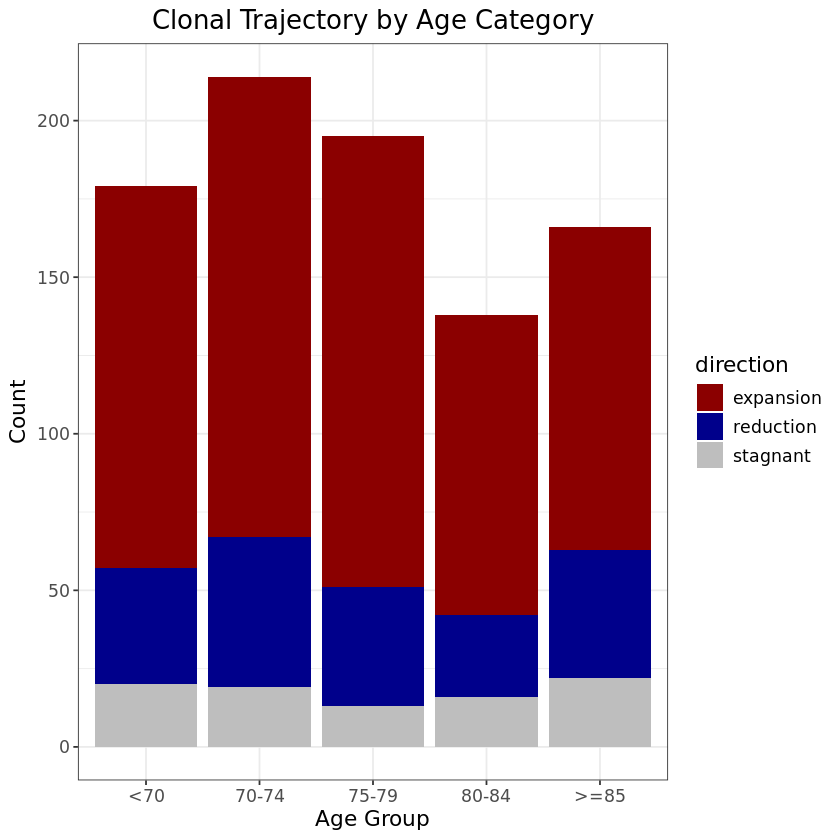

In [8]:
#prevalence of shrinking clones by age 
data$age_cat <-"<70"
data$age_cat[data$Age_B>=70 & data$Age_B<75] <-"70-74"
data$age_cat[data$Age_B>=75 & data$Age_B<80] <-"75-79"
data$age_cat[data$Age_B>=80 & data$Age_B<85] <-"80-84"
data$age_cat[data$Age_B>=85] <-">=85"

data$age_cat<-factor(data$age_cat, levels=c("<70","70-74","75-79","80-84",">=85"))
table(data$age_cat)

`summarise()` has grouped output by 'age_cat'. You can override using the
`.groups` argument.
Joining with `by = join_by(age_cat)`


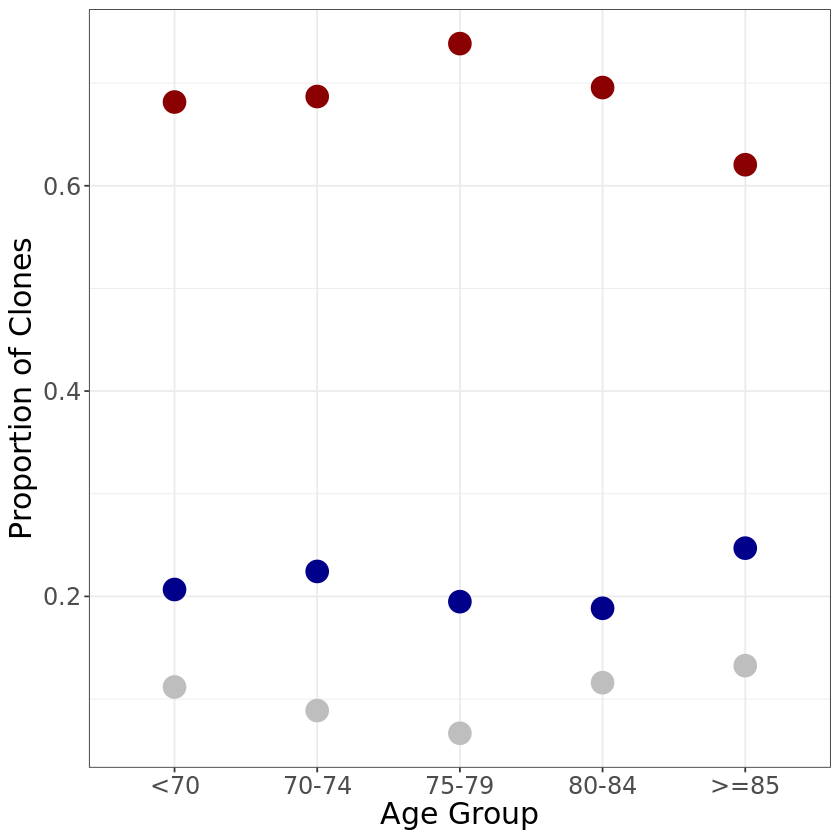

In [15]:
# group the data by age category and clone status, and count the number of clones in each group
grouped_counts <- data %>%
group_by(age_cat, direction) %>%
summarise(count = n())

# calculate the total number of clones in each age category
total_counts <- grouped_counts %>%
group_by(age_cat) %>%
summarise(total_count = sum(count))

# merge the grouped counts and total counts data frames
grouped_props <- grouped_counts %>%
left_join(total_counts)

# calculate the proportion of clones in each category for each age category
grouped_props <- grouped_props %>%
mutate(prop = count / total_count)

stagnant <-subset(grouped_props, direction=="stagnant")
expansion <-subset(grouped_props, direction=="expansion")
reduction <-subset(grouped_props, direction=="reduction")


stagnant$age_cat<-factor(stagnant$age_cat, levels=c("<70","70-74","75-79","80-84",">=85"))
expansion$age_cat<-factor(expansion$age_cat, levels=c("<70","70-74","75-79","80-84",">=85"))
reduction$age_cat<-factor(reduction$age_cat, levels=c("<70","70-74","75-79","80-84",">=85"))



# plot proportion of stagnant clones
h<-ggplot() +
geom_point(data=stagnant, aes(x = age_cat, y = prop, group = 1),color="grey", size=6) + geom_point(data=expansion, aes(x = age_cat, y = prop, group = 1),color="red4", size=6)+geom_point(data=reduction, aes(x = age_cat, y = prop, group = 1),color="blue4",size=6)+ labs(x="Age Group", y="Proportion of Clones") +theme_bw()+theme(plot.title = element_text(hjust = 0.5))+ theme(text = element_text(size = 18))
h
ggsave(h, filename = "age_cat_behavior_proportions.pdf",height = 7, width = 7)
system("gsutil cp age_cat_behavior_proportions.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

# Figure 3- mCAs & Pre-existing Phenotypes

## Checking for mCAs

In [29]:
system("gsutil cp gs://bicklab-main-storage/Users/Yash_Pershad/biovu_mca_calls/tara_Autosomal_MCA_to_BC_project_all_chrom_mca_calls.txt .")
mca_calls <-fread("tara_Autosomal_MCA_to_BC_project_all_chrom_mca_calls.txt")

system("gsutil cp gs://bicklab-main-storage/Users/Yash_Pershad/biovu_mca_calls/Complete_mCA_01_Counts.afterQC.withoutCF.021421.txt .")
mca_individuals<-fread("Complete_mCA_01_Counts.afterQC.withoutCF.021421.txt")
head(mca_individuals)
nrow(mca_individuals)

ourSid,has_MosaicCNV,Large_CNV_Clonev2,ChrX,ChrY,Autosomes,Large_ChrX,Large_ChrY,Large_Autosomes,computed_gender,Race,Ethnicity,birthDate,isDead,deathDate,lastRecordDate,DNADate,YAgeAtDNA,YAgeAtLastRecORDeath,SmokingStatus
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
R200000348,1,NA,NA,1,NA,NA,NA,NA,M,W,NH,3/6/37,0,NA,8/31/19,2/19/12,74,82,E
R200000649,0,0,NA,NA,0,NA,NA,0,M,B,NH,5/9/71,0,NA,8/28/19,8/1/12,41,48,E
R200002498,0,0,NA,NA,0,NA,NA,0,F,W,NH,4/8/39,1,1/15/18,1/15/18,7/13/14,75,78,E
R200002869,0,0,NA,NA,0,NA,NA,0,F,W,NH,12/6/32,0,NA,10/2/20,12/14/12,80,87,E
R200004714,0,0,NA,NA,0,NA,NA,0,M,W,NH,12/3/71,0,NA,4/19/19,6/24/09,37,47,E
R200007124,0,0,NA,NA,0,NA,NA,0,F,W,NH,3/25/43,0,NA,3/28/14,2/18/14,70,71,E


[1] 91505

In [31]:
colnames(mca_individuals)[1]<-"GRID"
merged<-merge(data, mca_individuals, by="GRID")
length(unique(merged$GRID))

merged_unique <-merged[!duplicated(merged$GRID)]
head(merged_unique)
table(merged_unique$has_MosaicCNV)

#display number of individuals with each type of mCA
table(merged_unique$Autosomes)
table(merged_unique$ChrX)
table(merged_unique$ChrY)


[1] 482

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race.x,has_MosaicCNV,Large_CNV_Clonev2,ChrX,ChrY,Autosomes,Large_ChrX,Large_ChrY,Large_Autosomes,computed_gender,Race.y,Ethnicity,birthDate,isDead,deathDate,lastRecordDate,DNADate,YAgeAtDNA,YAgeAtLastRecORDeath,SmokingStatus
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,7493-AB-967,2009-03-30,2017-12-24,0.001,0.033,55,64,0.032,8.7,0.49465800,expansion,M,W,0,0,NA,NA,0,NA,NA,0,M,W,NH,9/9/53,0,NA,3/23/20,3/30/09,55,66,E
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,9700-AB-0011,2012-02-21,2017-02-26,0.023,0.007,77,82,-0.016,5.0,-0.21173174,reduction,F,W,0,0,NA,NA,0,NA,NA,0,F,B,NH,1/27/96,0,NA,3/15/19,10/25/15,19,23,E
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,9700-AB-4476,2011-03-16,2015-03-28,0.271,0.348,83,87,0.077,4.0,0.06451672,expansion,M,W,1,1,NA,1,NA,NA,1,NA,M,W,NH,1/10/72,0,NA,11/28/19,12/4/07,35,47,E
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,9700-AB-1956,2012-10-20,2014-12-11,0.097,0.090,82,84,-0.007,2.1,-0.03503871,reduction,M,W,0,0,NA,NA,0,NA,NA,0,M,W,NH,2/3/46,0,NA,12/6/19,10/3/14,68,73,E
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,9700-AB-5773,2008-09-09,2016-11-05,0.024,0.003,64,72,-0.021,8.2,-0.22399043,reduction,M,W,1,NA,NA,1,NA,NA,NA,NA,M,B,NH,8/31/82,0,NA,1/17/20,11/19/12,30,37,E
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,9700-AB-0763,2014-09-30,2018-03-20,0.020,0.028,66,69,0.008,3.5,0.10090759,expansion,F,W,0,0,NA,NA,0,NA,NA,0,F,W,HL,6/4/52,0,NA,6/6/14,1/16/12,59,62,E



  0   1 
351 131 


  0   1 
351  44 


 1 
40 


 1 
57 

In [32]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
library(dplyr)
# individuals with multiple mCAs
merged_unique <- merged_unique %>%
mutate(Count_Ones = rowSums(select(., Autosomes, ChrX, ChrY) == 1, na.rm = TRUE))

# Filter rows where "Count_Ones" is at least 2
filtered_merged <- merged_unique %>%
filter(Count_Ones >= 2)
filtered_merged

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race.x,has_MosaicCNV,Large_CNV_Clonev2,ChrX,ChrY,Autosomes,Large_ChrX,Large_ChrY,Large_Autosomes,computed_gender,Race.y,Ethnicity,birthDate,isDead,deathDate,lastRecordDate,DNADate,YAgeAtDNA,YAgeAtLastRecORDeath,SmokingStatus,Count_Ones
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
R214842305,DNMT3A,chr2,25244289,25244289,G,A,stopgain,1935-08-16,7493-AB-395,7493-AB-082,2016-11-03,2018-05-10,0.067,0.042,81,82,-0.025,1.5,-0.26754155,reduction,F,W,1,1,1,NA,1,1,NA,NA,F,B,NH,10/10/37,0,NA,1/3/20,4/6/09,71,82,E,2
R223493671,DNMT3A,chr2,25240397,25240397,G,A,nonsynonymous SNV,1926-11-21,9700-AB-1512,9700-AB-0321,2012-12-24,2017-01-12,0.100,0.210,86,90,0.110,4.1,0.19836764,expansion,M,W,1,1,NA,1,1,NA,NA,1,M,W,NH,7/4/14,0,NA,9/8/06,9/8/06,92,92,M,2
R236796576,DNMT3A,chr2,25240358,25240358,-,A,stopgain,1942-11-16,9700-AB-4689,9700-AB-3438,2011-07-02,2017-09-11,0.052,0.026,68,74,-0.026,6.2,-0.10577507,reduction,M,W,1,NA,NA,1,1,NA,NA,NA,M,B,NH,8/8/15,0,NA,5/14/20,12/9/16,1,4,E,2
R241938887,TP53,chr17,7674241,7674241,G,C,nonsynonymous SNV,1928-11-12,9700-AB-3041,9700-AB-0102,2011-12-06,2016-05-13,0.035,0.033,83,87,-0.002,4.4,-0.01328382,stagnant,F,W,1,NA,1,NA,1,NA,NA,NA,F,B,NH,10/28/60,0,NA,4/26/16,4/8/14,53,55,E,2
R247579119,TET2,chr4,105236315,105236315,T,A,stopgain,1940-06-22,9700-AB-3519,9700-AB-2284,2012-04-22,2018-04-15,0.014,0.031,71,77,0.017,6.0,0.14166567,expansion,M,W,1,1,NA,1,1,NA,1,1,M,W,NH,3/9/55,0,NA,6/19/20,2/19/15,59,65,E,2
R249261774,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1943-02-19,7493-AB-158,7493-AB-470,2006-08-01,2007-08-12,0.143,0.183,63,64,0.040,1.0,0.27972028,expansion,M,W,1,NA,NA,1,1,NA,NA,NA,M,B,NH,1/22/76,0,NA,8/23/20,2/19/12,36,44,E,2
R259232093,TET2,chr4,105234592,105234592,C,-,frameshift deletion,1928-10-04,9700-AB-0086,9700-AB-1562,2013-01-07,2018-01-15,0.268,0.351,84,89,0.083,5.0,0.05544222,expansion,F,W,1,NA,1,NA,1,NA,NA,NA,F,B,NH,11/17/84,0,NA,5/19/17,6/21/11,26,32,E,2
R266907391,DNMT3A,chr2,25234290,25234290,C,G,nonsynonymous SNV,1934-10-24,9700-AB-1270,9700-AB-2870,2011-12-20,2020-09-16,0.025,0.067,77,85,0.042,8.7,0.11998162,expansion,M,W,1,NA,NA,1,1,NA,NA,NA,M,W,NH,8/9/79,0,NA,10/9/19,11/25/12,33,40,E,2
R280744488,TET2,chr4,105272692,105272692,-,A,frameshift insertion,1929-02-06,9700-AB-2950,9700-AB-4454,2008-01-14,2011-09-13,0.028,0.054,78,82,0.026,3.7,0.19423759,expansion,F,W,1,1,1,NA,1,NA,NA,1,F,B,NH,12/12/94,0,NA,8/2/20,2/12/17,22,25,E,2


In [33]:
# rank inverse normal transform the data 

ranks <- rank(merged$Growth_Rate)

# Compute the z-scores
z_scores <- qnorm((ranks - 0.5) / length(merged$Growth_Rate))

# Replace the original data with the transformed z-scores
merged$Growth_Rate <- z_scores
head(merged)


GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race.x,has_MosaicCNV,Large_CNV_Clonev2,ChrX,ChrY,Autosomes,Large_ChrX,Large_ChrY,Large_Autosomes,computed_gender,Race.y,Ethnicity,birthDate,isDead,deathDate,lastRecordDate,DNADate,YAgeAtDNA,YAgeAtLastRecORDeath,SmokingStatus
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,7493-AB-967,2009-03-30,2017-12-24,0.001,0.033,55,64,0.032,8.7,1.63314253,expansion,M,W,0,0,NA,NA,0,NA,NA,0,M,W,NH,9/9/53,0,NA,3/23/20,3/30/09,55,66,E
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,9700-AB-0011,2012-02-21,2017-02-26,0.023,0.007,77,82,-0.016,5.0,-1.87960009,reduction,F,W,0,0,NA,NA,0,NA,NA,0,F,B,NH,1/27/96,0,NA,3/15/19,10/25/15,19,23,E
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,9700-AB-4476,2011-03-16,2015-03-28,0.271,0.348,83,87,0.077,4.0,-0.00407583,expansion,M,W,1,1,NA,1,NA,NA,1,NA,M,W,NH,1/10/72,0,NA,11/28/19,12/4/07,35,47,E
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,9700-AB-1956,2012-10-20,2014-12-11,0.097,0.090,82,84,-0.007,2.1,-0.98052047,reduction,M,W,0,0,NA,NA,0,NA,NA,0,M,W,NH,2/3/46,0,NA,12/6/19,10/3/14,68,73,E
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,9700-AB-5773,2008-09-09,2016-11-05,0.024,0.003,64,72,-0.021,8.2,-1.98491013,reduction,M,W,1,NA,NA,1,NA,NA,NA,NA,M,B,NH,8/31/82,0,NA,1/17/20,11/19/12,30,37,E
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,9700-AB-0763,2014-09-30,2018-03-20,0.020,0.028,66,69,0.008,3.5,0.26810579,expansion,F,W,0,0,NA,NA,0,NA,NA,0,F,W,HL,6/4/52,0,NA,6/6/14,1/16/12,59,62,E


In [35]:
p<-lm(data=merged, formula=Growth_Rate ~ has_MosaicCNV+Age_A+Sex)
summary(p)


Call:
lm(formula = Growth_Rate ~ has_MosaicCNV + Age_A + Sex, data = merged)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1634 -0.6459 -0.0003  0.6810  3.0821 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)  
(Intercept)    0.596431   0.291573   2.046   0.0412 *
has_MosaicCNV  0.109765   0.091327   1.202   0.2299  
Age_A         -0.009588   0.004224  -2.270   0.0236 *
SexM           0.086934   0.081762   1.063   0.2881  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9967 on 611 degrees of freedom
Multiple R-squared:  0.01094,	Adjusted R-squared:  0.006082 
F-statistic: 2.252 on 3 and 611 DF,  p-value: 0.08117


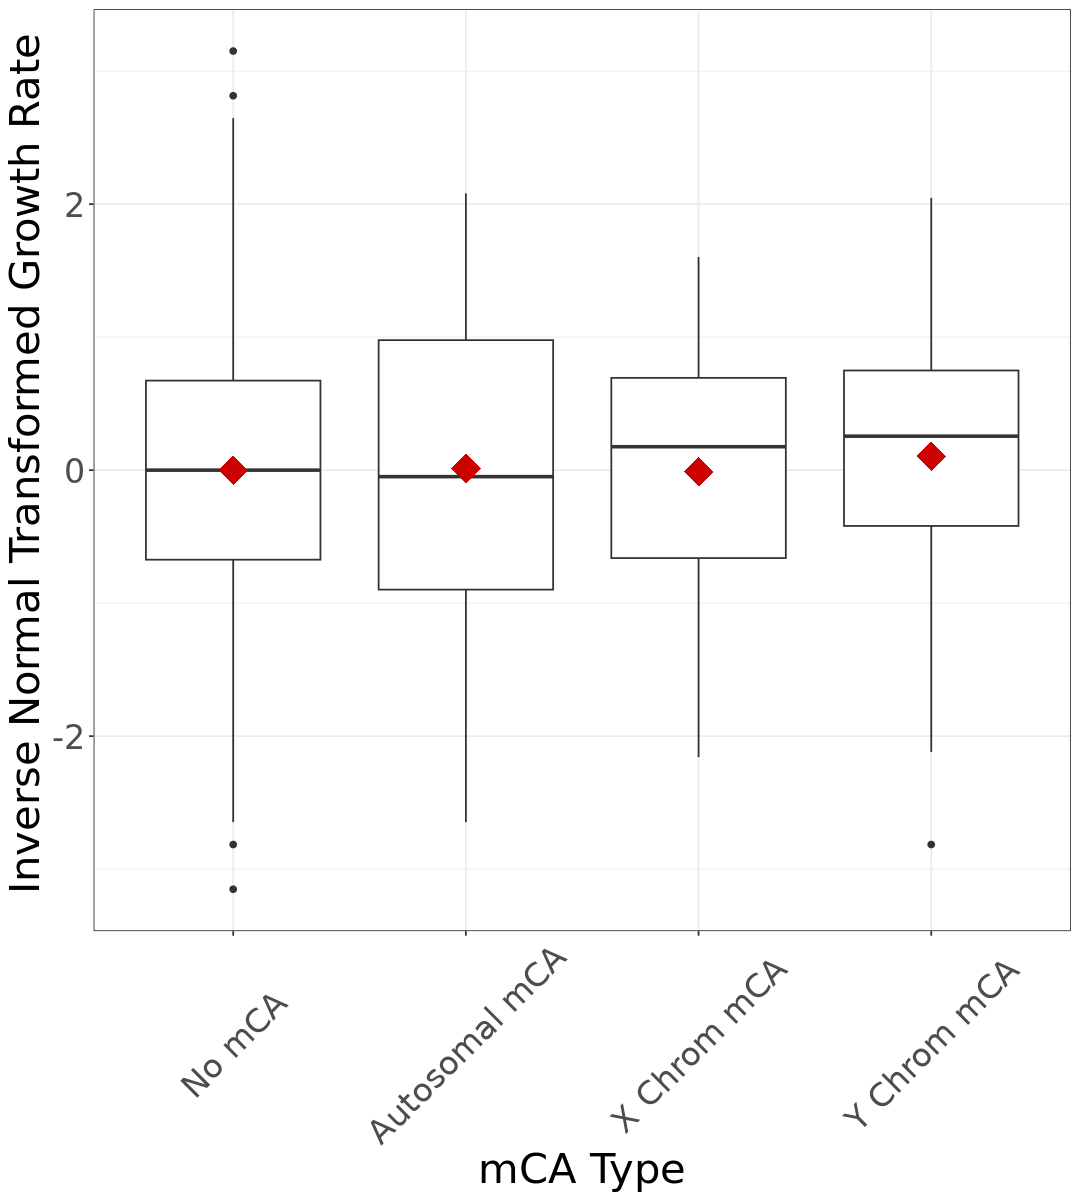

In [38]:
options(repr.plot.width=9, repr.plot.height=10)
#making a boxplot 

# Reshape data to longer format
merged_long <- merged %>%
pivot_longer(cols = c(has_MosaicCNV, ChrX, ChrY, Autosomes),
names_to = "Category",
values_to = "Value")

# Filter for the desired categories
merged_long <- merged_long %>% filter(Value == 1 | (Category == "has_MosaicCNV" & Value == 0))
merged_long$Category[merged_long$Category=="has_MosaicCNV"]<-"No mCA"
merged_long$Category[merged_long$Category=="Autosomes"]<-"Autosomal mCA"
merged_long$Category[merged_long$Category=="ChrX"]<-"X Chrom mCA"
merged_long$Category[merged_long$Category=="ChrY"]<-"Y Chrom mCA"

merged_long$Category<-factor(merged_long$Category, levels=c("No mCA", "Autosomal mCA", "X Chrom mCA", "Y Chrom mCA"))


# Create boxplot
p<-ggplot(merged_long, aes(x = Category, y = Growth_Rate)) +
geom_boxplot() + stat_summary(fun=mean, geom="point", shape=18, size=8, color="red3") +
labs(
x = "mCA Type",
y = " Inverse Normal Transformed Growth Rate")+theme_bw()+ theme(text = element_text(size = 25))+ theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))
p
ggsave(p, filename = "mCA_growth_rate.pdf",height = 10, width = 9)
system("gsutil cp mCA_growth_rate.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

In [25]:
# ANOVA test 
anova_result <- aov(Growth_Rate ~ Category+Age_A+Sex, data = merged_long)
summary(anova_result)


             Df Sum Sq Mean Sq F value Pr(>F)
Category      3    0.8  0.2532   0.249  0.862
Age_A         1    2.4  2.4104   2.373  0.124
Sex           1    1.8  1.7912   1.763  0.185
Residuals   800  812.6  1.0158               

## PheWAS before Timepoint 2- pre-existing conditions

In [ ]:
#bringing in mtp individuals
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/MTP_Dataset_May24.txt .")
biovu_mtp <- fread("MTP_Dataset_May24.txt")

#coverting to person ids
system("gsutil cp gs://bicklab-main-storage/Data/BioVU/BioVU_GRID_to_personid_conversion.txt .")
grid_conversions <-fread("BioVU_GRID_to_personid_conversion.txt")

#collecting all codes 
individuals <-merge(biovu_mtp, grid_conversions, by="GRID")
individuals <-distinct(individuals, person_id, .keep_all = TRUE)


id_string <- paste(individuals$person_id, collapse = ", ")

sql <- paste0("
  SELECT *
  FROM `sd-vumc-tanagra-test.terra_sd_20230831.x_codes`
  WHERE person_id IN (", id_string, ")
")

projectid <- "sd-vumc-tanagra-test"
data <- bq_project_query(projectid, sql)
icd_codes <- bq_table_download(data)

#subsetting to only the icd codes 
icd_only <-subset(icd_codes, vocabulary_id=="ICD10CM"|vocabulary_id=="ICD9CM")
icd_only <-icd_only[,c(1,2,4,5,6,7,11)]
head(icd_only)

# subsetting to only icd codes that occur before TP 2
merged <-merge(icd_only, individuals, by="person_id")
merged<-merged[merged$age_at_event <= merged$Age_B,]

icd_only <-merged[,c(1,5,6,7)]
icd_only$vocabulary_id <- gsub("[^0-9.]", "", icd_only$vocabulary_id)
colnames(icd_only)<-c("id", "ICD_CODE", "ICD_TYPE", "AgeAtICD")
head(icd_only)

write.table(icd_only, "Growth_Rate_Phenotype_Before_TP2.csv", sep=",", quote=F, col.names=T, row.names=F)
system("gsutil cp Growth_Rate_Phenotype_Before_TP2.csv gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/")

#bring in group file 
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/no_time_filters/Growth_Rate_PheWAS_group_file.csv .")


In [ ]:
##switch to python kernel
#code to run phewas analyses
! pyPhewasPipeline --reg_type lin --target Growth_Rate --covariates Age_A+Gene+Sex+Race --phenotype Growth_Rate_Phenotype_Before_TP2.csv --group Growth_Rate_PheWAS_group_file.csv --path /home/jupyter/VICTR_BioVU_pilot_Bick_lab/edit/

#save results 
!gsutil cp Manhattan_bon_Age_A+Gene+Sex+Race_Growth_Rate_PheWAS_group_file.png gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/
!gsutil cp regressions_Age_A+Gene+Sex+Race_Growth_Rate_PheWAS_group_file.csv gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/

In [1]:
#isolating relevant phecodes for the regressions and plots 

system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/Growth_Rate_Phenotype_Before_TP2.csv .")
icd_codes <-fread("Growth_Rate_Phenotype_Before_TP2.csv")
head(icd_codes)

#converting to phecodes 
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/phecode_icd10.csv .")
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/phecode_icd9_rolled.csv .")
icd_10<-fread("phecode_icd10.csv")
icd_9<-fread("phecode_icd9_rolled.csv")

colnames(icd_10)[1]<-"ICD_CODE"
colnames(icd_10)[2]<-"ICD_Desc"
icd_10<-icd_10[,c(1:4)]

colnames(icd_9)[1]<-"ICD_CODE"
colnames(icd_9)[2]<-"ICD_Desc"
icd_9<-icd_9[,c(1:4)]

icd_conversion <-rbind(icd_9, icd_10)

icd_merged<-merge(icd_codes, icd_conversion, by="ICD_CODE")
head(icd_merged)

id,ICD_CODE,ICD_TYPE,AgeAtICD
<int>,<chr>,<int>,<int>
4481,250.00,9,67
4481,729.5,9,70
4481,592.0,9,60
4481,110.1,9,66
4481,592.1,9,58
4481,Z00.01,10,74


ICD_CODE,id,ICD_TYPE,AgeAtICD,ICD_Desc,PheCode,Phenotype
<chr>,<int>,<int>,<int>,<chr>,<dbl>,<chr>
003.1,1316310,9,67,Salmonella septicemia,38.1,Gram negative septicemia
003.1,1316310,9,67,Salmonella septicemia,38.1,Gram negative septicemia
003.1,1316310,9,67,Salmonella septicemia,38.1,Gram negative septicemia
003.1,1316310,9,67,Salmonella septicemia,38.1,Gram negative septicemia
003.1,1316310,9,67,Salmonella septicemia,38.1,Gram negative septicemia
003.9,1316310,9,67,Salmonella infection NOS,8.5,Bacterial enteritis


In [2]:
library(dplyr)
blood_cancer_remove <-subset(icd_merged, PheCode >=200 & PheCode <205)
keep_individuals<-anti_join(icd_merged, blood_cancer_remove, by="id")
length(unique(keep_individuals$id))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 705

In [67]:
# Ensure PheCode is numeric
keep_individuals$PheCode <- as.numeric(keep_individuals$PheCode)

# Define a list of conditions with their respective PheCode ranges
conditions <- list(
  solid_tumor = list(ranges = list(c(145, 146), c(149, 196), c(198, 231))),
  diabetes = list(ranges = list(c(250.2, 250.3))),
  vascular_hd = list(ranges = list(c(394, 396))),
  hypertension = list(ranges = list(c(401, 402))),
  ath_cad = list(ranges = list(c(411, 415), c(440, 441))),
  cardiomyopathy = list(ranges = list(c(425, 426))),
  arrhythmia = list(ranges = list(c(426, 428))),
  heart_failure = list(ranges = list(c(428, 430))),
  hfref = list(ranges = list(c(428.3, 428.4))), 
  hfpef = list(ranges = list(c(428.4, 428.5))), 
  cerebrovascular_disease = list(ranges = list(c(433, 434))),
  giant_cell_arthritis = list(ranges = list(c(446.5, 446.6))),
  copd = list(ranges = list(c(496, 497))),
  liver_cirrhosis = list(ranges = list(c(571, 572))),
  ckd = list(ranges = list(c(585, 586))),
  lupus = list(ranges = list(c(695.42, 695.43))),
  rheumatoid_arthritis = list(ranges = list(c(714, 715))),
  sepsis = list(ranges = list(c(994, 995)))
)

# Function to check if a PheCode falls within any of the specified ranges
is_in_ranges <- function(phecode, ranges) {
  any(sapply(ranges, function(range) phecode >= range[1] && phecode <= range[2]))
}

# Process the data for each condition
for (condition in names(conditions)) {
  ranges <- conditions[[condition]]$ranges
  keep_individuals[[condition]] <- ifelse(sapply(keep_individuals$PheCode, is_in_ranges, ranges = ranges), 1, 0)
}

# Summarize the data to one row per individual, replacing NAs with 0
everyone <- keep_individuals %>%
  group_by(id) %>%
  summarize(across(everything(), max, na.rm = TRUE)) %>%
  mutate(across(everything(), ~ replace_na(., 0)))

# Print the resulting data frame
nrow(everyone)
head(everyone)


Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(everything(), max, na.rm = TRUE)`.
ℹ In group 1: `id = 4481`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


[1] 705

id,ICD_CODE,ICD_TYPE,AgeAtICD,ICD_Desc,PheCode,Phenotype,solid_tumor,diabetes,vascular_hd,⋯,hfref,hfpef,cerebrovascular_disease,giant_cell_arthritis,copd,liver_cirrhosis,ckd,lupus,rheumatoid_arthritis,sepsis
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4481,Z96.1,10,74,Vitreous membranes and strands,1010,Visual field defects,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
19127,Z85.3,10,78,Vitamin d deficiency NOS,1010,Vitamin D deficiency,1,0,0,⋯,0,0,0,0,0,1,0,0,0,0
19252,Z96.1,10,70,"Vitamin D deficiency, unspecified",1013,Voice disturbance,1,1,1,⋯,0,0,0,0,1,0,1,0,0,0
19369,Z95.5,10,82,Ventricular premature depolarization,1010,Unstable angina (intermediate coronary syndrome),1,0,1,⋯,0,0,0,0,0,0,1,0,0,1
21272,V06.5,10,67,Unspecified disease of sebaceous glands,1010,Symptoms involving respiratory system and other chest symptoms,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
23772,Z95.5,10,77,"Urinary tract infection, site not specified",1100,Urinary tract infection,1,1,1,⋯,0,0,1,0,1,0,1,0,0,0


In [73]:
# bringing in mtp individuals
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/MTP_Dataset_May24.txt .")
biovu_mtp <- fread("MTP_Dataset_May24.txt")

#coverting to person ids
system("gsutil cp gs://bicklab-main-storage/Data/BioVU/BioVU_GRID_to_personid_conversion.txt .")
grid_conversions <-fread("BioVU_GRID_to_personid_conversion.txt")

individuals <-merge(biovu_mtp, grid_conversions, by="GRID")
individuals <-distinct(individuals, person_id, .keep_all = TRUE)
# head(individuals)

In [74]:
colnames(everyone)[1]<-"person_id"
merged <-merge(everyone, individuals, by="person_id")
head(merged)

,person_id,ICD_CODE,ICD_TYPE,AgeAtICD,ICD_Desc,PheCode,Phenotype,solid_tumor,diabetes,vascular_hd,⋯,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race
,<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,4481,Z96.1,10,74,Vitreous membranes and strands,1010,Visual field defects,0,1,0,⋯,0.028,0.033,64,74,0.005,10.3,0.016079661,expansion,F,B
2,19127,Z85.3,10,78,Vitamin d deficiency NOS,1010,Vitamin D deficiency,1,0,0,⋯,0.021,0.044,71,78,0.023,6.4,0.122516455,expansion,F,W
3,19252,Z96.1,10,70,"Vitamin D deficiency, unspecified",1013,Voice disturbance,1,1,1,⋯,0.027,0.030,60,70,0.003,9.7,0.010921114,stagnant,F,W
4,19369,Z95.5,10,82,Ventricular premature depolarization,1010,Unstable angina (intermediate coronary syndrome),1,0,1,⋯,0.080,0.085,74,82,0.005,8.0,0.007606864,stagnant,M,W
5,21272,V06.5,10,67,Unspecified disease of sebaceous glands,1010,Symptoms involving respiratory system and other chest symptoms,1,0,0,⋯,0.030,0.077,59,67,0.047,7.7,0.130224888,expansion,M,A
6,23772,Z95.5,10,77,"Urinary tract infection, site not specified",1100,Urinary tract infection,1,1,1,⋯,0.082,0.102,74,77,0.020,3.4,0.066297348,expansion,F,W


In [12]:
# List of conditions
conditions <- c("solid_tumor", "diabetes", "vascular_hd", "hypertension", "ath_cad",
                "cardiomyopathy", "arrhythmia", "heart_failure", "hfref", "hfpef", 
                "cerebrovascular_disease", "giant_cell_arteritis", "copd", "liver_cirrhosis",
                "ckd", "lupus", "rheumatoid_arthritis", "sepsis")

# Function to run the regression and extract results
run_regression <- function(condition) {
  formula <- as.formula(paste(condition, "~ Growth_Rate + Age_A + Sex"))
  model <- lm(data = merged, formula = formula)
  summary_model <- summary(model)
  conf_int <- confint(model, "Growth_Rate", level = 0.95)
  
  # Extract the desired values
  p_value <- coef(summary_model)["Growth_Rate", "Pr(>|t|)"]
  beta_value <- coef(summary_model)["Growth_Rate", "Estimate"]
  std_error <- coef(summary_model)["Growth_Rate", "Std. Error"]
  ci_lower <- conf_int[1]
  ci_upper <- conf_int[2]
  
  # Count the number of individuals with a 1 for the condition
  num_individuals <- sum(merged[[condition]] == 1, na.rm = TRUE)
  
  # Return a data frame with the results
  return(data.frame(
    Condition = condition,
    NumIndividuals = num_individuals,
    Beta = beta_value,
    StdError = std_error,
    PValue = p_value,
    CI_Lower = ci_lower,
    CI_Upper = ci_upper
  ))
}

# Run regression for each condition and store the results
results_list <- lapply(conditions, run_regression)

# Combine all results into one data frame
results_df <- bind_rows(results_list)

# Print the results data frame
results_df



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ERROR: Error in str2lang(x): <text>:1:7: unexpected symbol
1: Solid Organ
          ^


In [79]:
write.table(results_df, "Before_TP2_Regressions.txt", sep="\t", quote=F, col.names=T, row.names=F)
system("gsutil cp Before_TP2_Regressions.txt gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/")

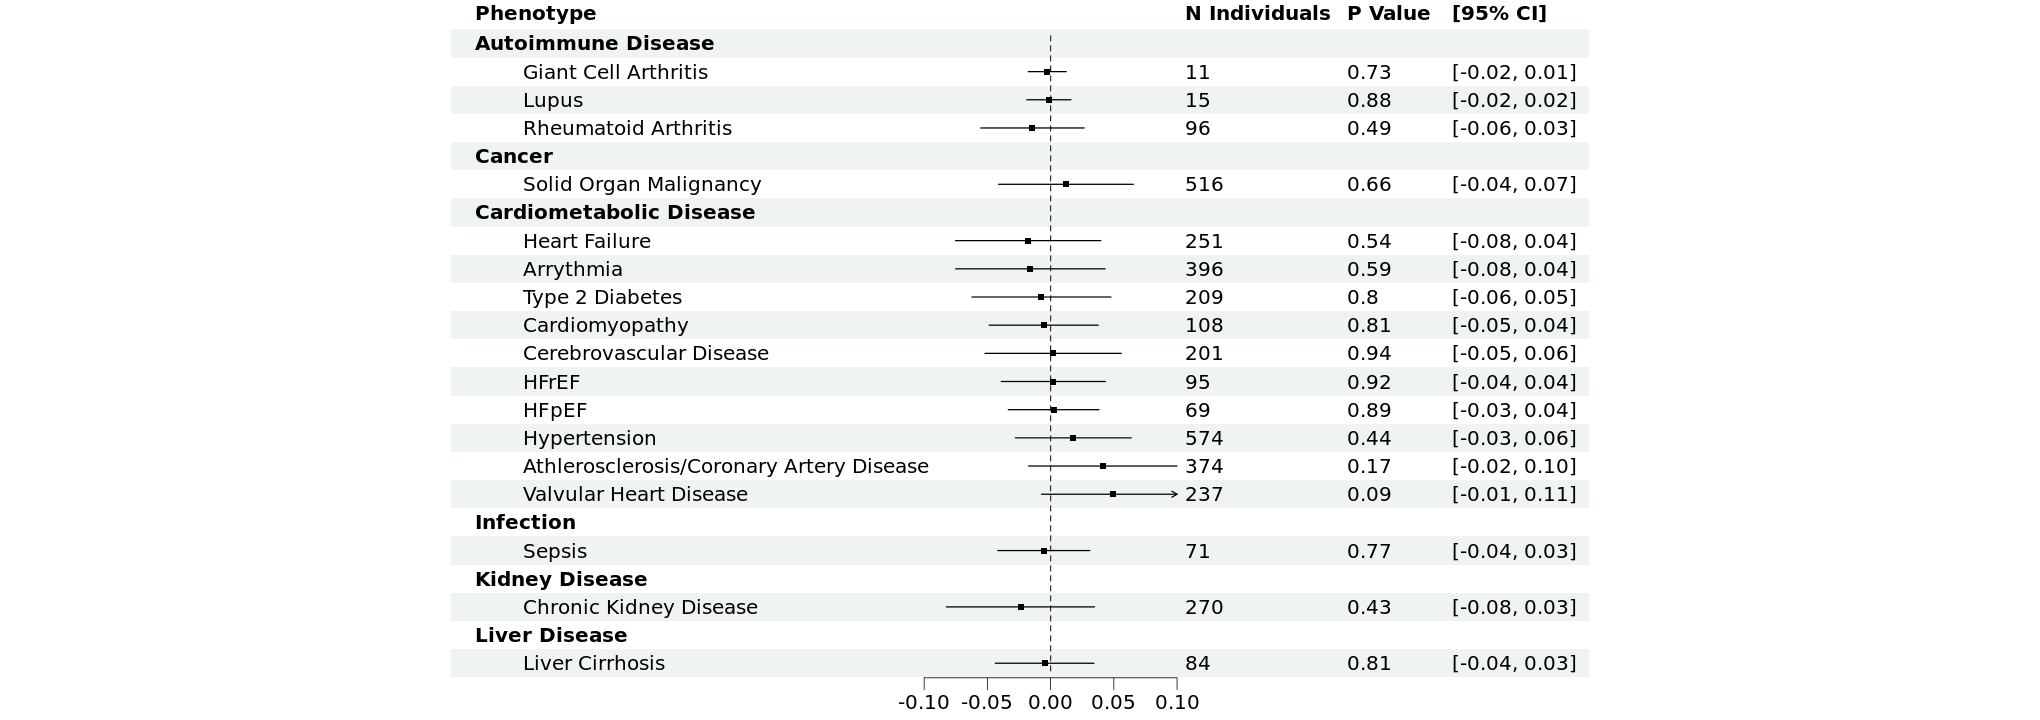

In [11]:
options(repr.plot.width=17, repr.plot.height=6)

system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/Before_TP2_Regressions.txt .")
# #making the forest plot 
results <-fread("Before_TP2_Regressions.txt")

results<- results[order(results$Beta), ]

head(results)

results$''<-paste(rep(" ", 20), collapse=" ")
results$`[95% CI]` <- ifelse(is.na(results$StdError), "",
                             sprintf("[%.2f, %.2f]",
                                      results$CI_Lower, results$CI_Upper))
results<-results[,c(1,8,2,5,9,3,4,6,7)]
results$PValue <- round(results$PValue, 2)
results$Phenotype <- ifelse(is.na(results$PValue), 
                      results$Phenotype,
                      paste0("        ", results$Phenotype))
results$PValue <- ifelse(is.na(results$PValue), "", results$PValue)
results$'N Individuals' <- ifelse(is.na(results$'N Individuals'), "", results$'N Individuals')
colnames(results)[4]<-"P Value"

p<-forest(results[,c(1:2,3:5)], est=results$Beta, lower=results$CI_Lower, upper=results$CI_Upper, sizes=0.4, ci_column=2, ref_line=0, ticks_digits=2, xlim=c(-0.1, 0.1))
library(grid)
g <- edit_plot(p,
               row = c(1, 5, 7, 18,20,22),
               gp = gpar(fontface = "bold"))
g
# ggsave function
ggplot2::ggsave(filename = "Pre_TP2_Regressions_Forest_Plot.pdf", plot = g,
                dpi = 300,
                width = 12, height = 12, units = "in")
system("gsutil cp Pre_TP2_Regressions_Forest_Plot.pdf gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/Clonal_Expansion_Rate/before_TP2/")

# Figure 2- Multiple Clones 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


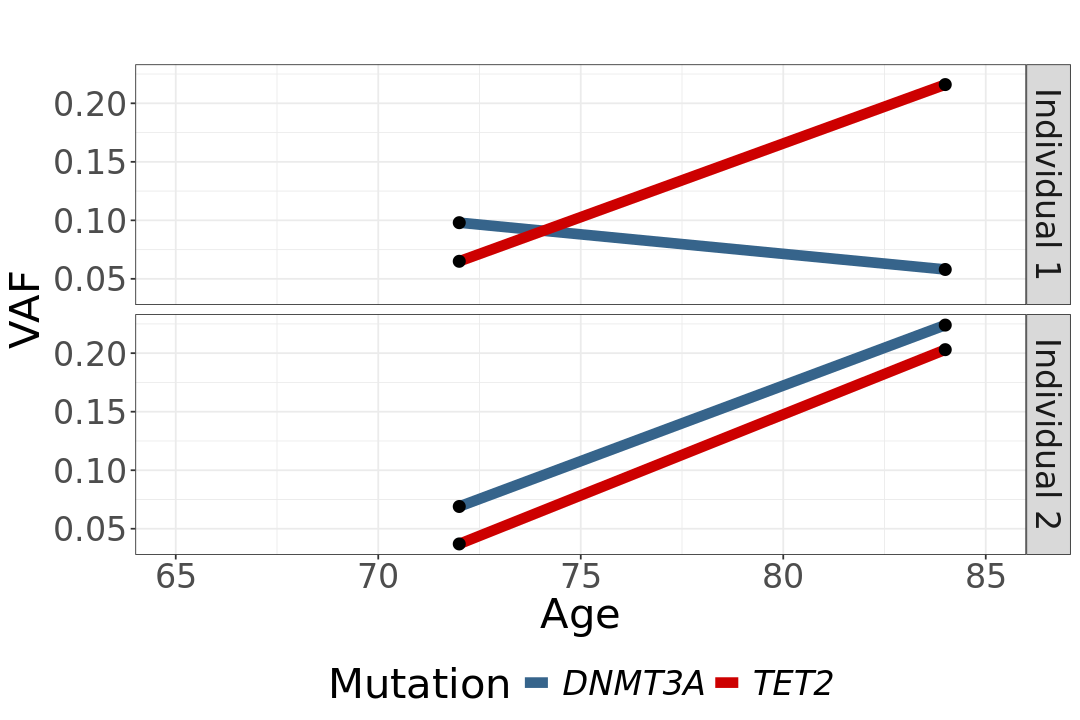

In [3]:
#making toy example 
options(repr.plot.width=9, repr.plot.height=6)
toy_example <- data.frame(GRID=c("Individual 1", "Individual 1", "Individual 2", "Individual 2"),
                 AF_A=c(0.098, 0.065, 0.069, 0.037),
                 AF_B=c(0.058, 0.216, 0.224, 0.203), 
                          Age_A=c(72, 72,72, 72), 
                          Age_B=c(84, 84, 84, 84), 
                         Gene=c("DNMT3A", "TET2","DNMT3A", "TET2"))



p<-ggplot(toy_example) + 
  geom_segment(aes(y = AF_A, yend = AF_B, x=Age_A, xend = Age_B, color=Gene), size=3)+
 geom_point(aes(x=Age_A,y = AF_A), size=3) + 
  geom_point(aes(x=Age_B,y = AF_B), size=3)+ facet_grid(GRID~., scales="free_x")+theme_bw()+ labs(color = "Mutation", x="Age", y="VAF", title="") +theme(plot.title = element_text(hjust = 0.5))+theme(axis.text.x =element_text())+ theme(text = element_text(size = 18))+scale_color_manual(values=c("steelblue4", "red3"))+xlim(65,85)+ theme(text = element_text(size = 25))+ theme(legend.position = "bottom")+theme(legend.text = element_text(face = "italic"))
p
ggsave(p, filename = "cooccurence_descriptive.pdf",height = 6, width = 9)
system("gsutil cp cooccurence_descriptive.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

In [3]:
library(dplyr)
data<-data %>%
  add_count(GRID, name = 'mutations')

two_mut <-subset(data, mutations=="2")
two_mut$Gene[two_mut$Gene=="SRSF2"|two_mut$Gene=="SF3B1"] <-"SRSF2/SF3B1"
nrow(two_mut)

[1] 232

In [49]:
# # create an upset plot of the different combinations 

options(repr.plot.width=12, repr.plot.height=8)
pdf("upset_plot.pdf", width = 10, height = 8)

# create a binary matrix of gene presence/absence for each individual
binary_matrix <- table(two_mut$Gene, two_mut$GRID)
df_long <- melt(binary_matrix)
colnames(df_long) <- c("Gene", "GRID", "present")

df_grid <- dcast(df_long, GRID ~ Gene, value.var = "present", fill = 0)
rownames(df_grid) <- df_grid$GRID
df_grid$GRID <- NULL

upset(df_grid,order.by = "freq",nsets = ncol(df_grid),sets.bar.color = "slategray",matrix.color="black")

dev.off()
system("gsutil cp upset_plot.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

Warning message in melt(binary_matrix):
“The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(binary_matrix). In the next version, this warning will become an error.”
Warning message in dcast(df_long, GRID ~ Gene, value.var = "present", fill = 0):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(df_long). In the next version, this warning will become an error.”


png 
  2

In [45]:
#categorizing as distinct vs sub clones 

# Z-score calculation function
z_score <- function(x) {
  (x - mean(x)) / sd(x)
}

# Z-score growth rates within each clonal category
two_mut <- two_mut %>%
  group_by(direction) %>%
  mutate(ZScore = z_score(Growth_Rate))

two_mut_diff <- two_mut %>%
  group_by(GRID) %>%
  summarise(ZScoreDiff = diff(ZScore))

two_mut <-merge(two_mut, two_mut_diff, by="GRID")

categories <- two_mut %>%
  group_by(direction, GRID) %>%
  mutate(Category = case_when(
      n() == 2 & direction[1] != direction[2] | abs(ZScoreDiff) > 0.6 ~ "distinct",
      TRUE ~ "sub-clone"
    )
  )
head(categories)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,mutations,ZScore,ZScoreDiff,Category
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
R201566273,DNMT3A,chr2,25244559,25244559,C,T,nonsynonymous SNV,1933-09-02,9700-AB-2448,⋯,-0.006,5.4,-0.02678358,reduction,F,W,2,0.61913271,-1.2084430,distinct
R201566273,TET2,chr4,105236739,105236739,C,T,stopgain,1933-09-02,9700-AB-2448,⋯,0.004,5.4,0.02272868,expansion,F,W,2,-0.58931033,-1.2084430,distinct
R203072914,ASXL1,chr20,32435552,32435552,A,AG,frameshift insertion,1925-08-10,7493-AB-205,⋯,0.025,4.2,0.01823788,expansion,F,W,2,-0.60566882,0.1365134,sub-clone
R203072914,TET2,chr4,105261850,105261850,T,G,splicing,1925-08-10,7493-AB-205,⋯,0.067,4.2,0.05571413,expansion,F,W,2,-0.46915540,0.1365134,sub-clone
R206049184,DNMT3A,chr2,25240715,25240715,G,C,nonsynonymous SNV,1937-07-14,9700-AB-1131,⋯,0.059,6.0,0.08532575,expansion,F,W,2,-0.36129021,0.3122481,sub-clone
R206049184,TET2,chr4,105243636,105243636,T,A,nonsynonymous SNV,1937-07-14,9700-AB-1131,⋯,0.060,6.0,0.17104544,expansion,F,W,2,-0.04904214,0.3122481,sub-clone


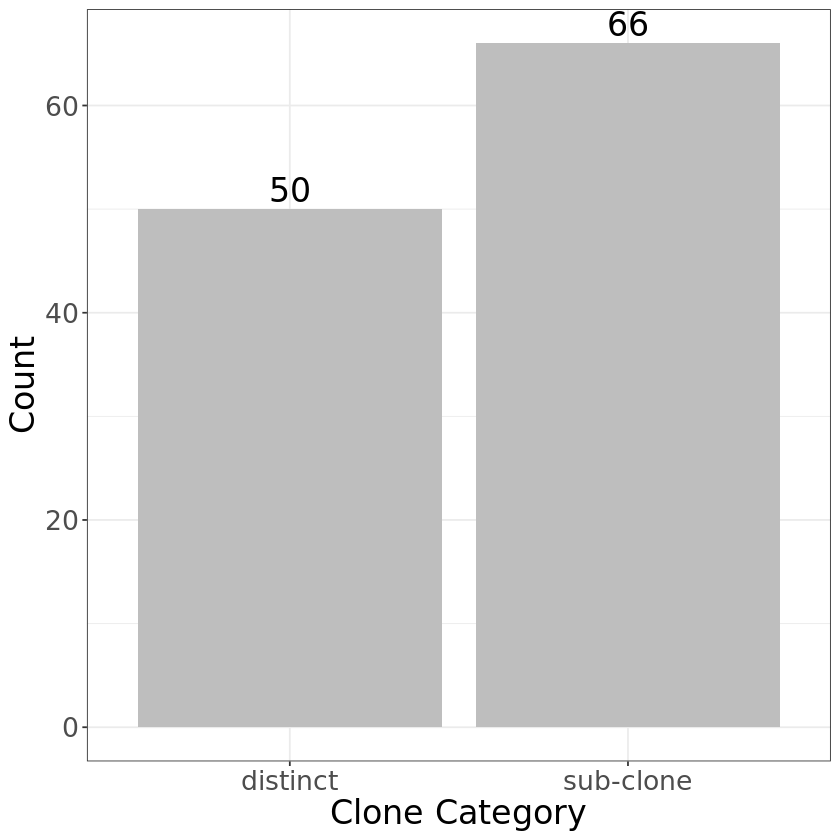

In [49]:
options(repr.plot.width=7, repr.plot.height=7)
two_mut_unique <- categories[!duplicated(categories$GRID), ]
h<-ggplot(two_mut_unique, aes(x=Category)) +
    geom_bar(position="stack", stat="count", fill="grey")+theme_bw()+ labs(x="Clone Category", y="Count")+geom_text(stat='count', aes(label=..count..), size=7, vjust=-0.3) + theme(text = element_text(size=20))
h
ggsave(h, filename = "clonal_category_distribution_barplot.pdf",height = 7, width = 7)
system("gsutil cp clonal_category_distribution_barplot.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

In [39]:
length(unique(two_mut_unique$GRID))
table(two_mut_unique$Category)
nrow(two_mut_unique)

[1] 116


 distinct sub-clone 
       79        88 

[1] 167

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing non-finite outside the scale range
(`stat_boxplot()`).”



Call:
lm(formula = Growth_Rate ~ Category + Age_A + Gene + Sex, data = fastest_growing)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38832 -0.13865 -0.02639  0.06507  2.47640 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)        0.721347   0.264096   2.731  0.00741 **
Categorysub-clone -0.147173   0.060796  -2.421  0.01722 * 
Age_A             -0.005399   0.003060  -1.764  0.08066 . 
GeneCBL           -0.102704   0.266298  -0.386  0.70053   
GeneDNMT3A        -0.115257   0.144702  -0.797  0.42755   
GeneGNB1           0.013946   0.268080   0.052  0.95861   
GeneJAK2          -0.227540   0.260167  -0.875  0.38381   
GenePPM1D         -0.050247   0.191311  -0.263  0.79334   
GeneSRSF2/SF3B1    0.187215   0.185647   1.008  0.31558   
GeneTET2           0.007857   0.144137   0.055  0.95663   
GeneTP53          -0.061662   0.198907  -0.310  0.75718   
SexM              -0.008596   0.066093  -0.130  0.89677   
---
Signif. codes:  0 ‘**

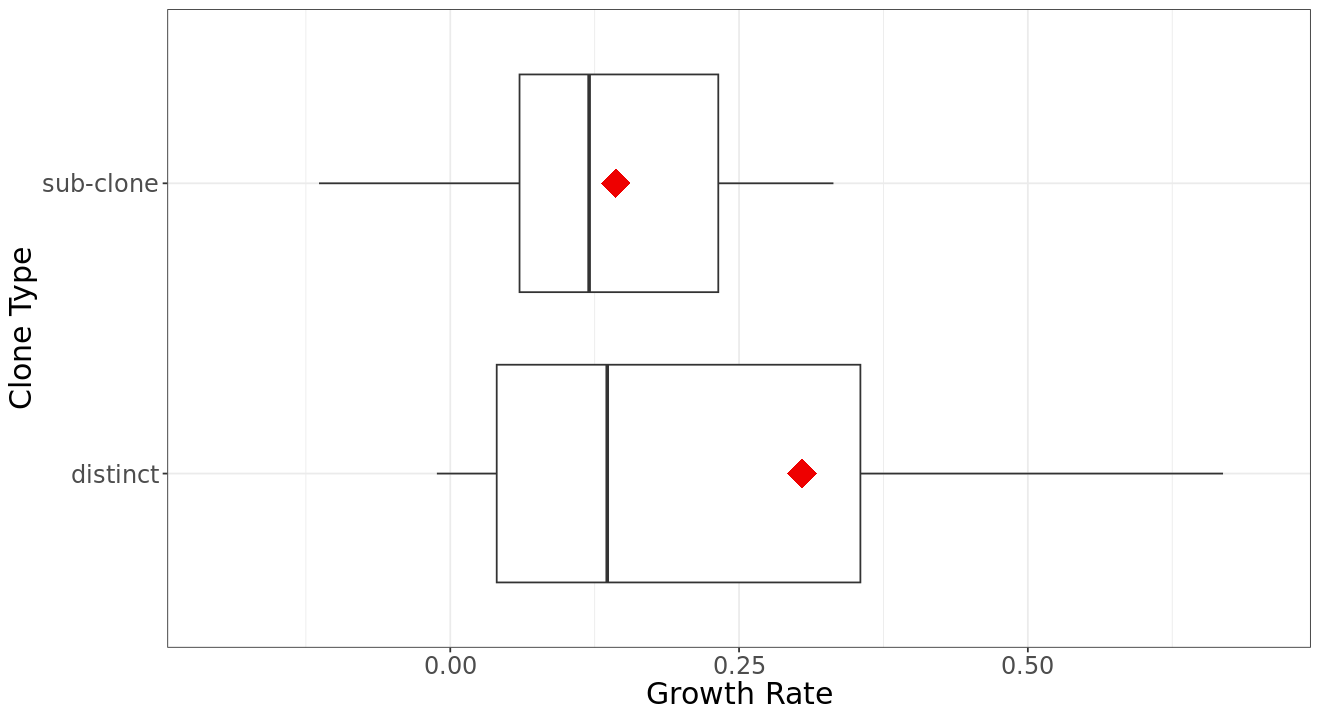

In [63]:
options(repr.plot.width=11, repr.plot.height=6)
fastest_growing <-categories %>% group_by(GRID) %>% top_n(1, Growth_Rate)

gene_avg_growth <- fastest_growing %>%
  group_by(Category) %>%
  summarize(avg_growth = mean(Growth_Rate))

h<-ggplot(fastest_growing, aes(x = Growth_Rate, y = reorder(Category, -Growth_Rate))) + geom_boxplot()+ theme(text = element_text(size = 25))+
   theme_bw()+ labs(color = "Type", x="Growth Rate", y="Clone Type")+ scale_color_manual(values=c("darkred", "darkblue")) +theme(plot.title = element_text(hjust = 0.5),text = element_text(size = 18))+stat_summary(data = gene_avg_growth, aes(x = avg_growth, y = Category), 
               fun.y = mean, geom = "point", 
               shape = 18, size = 8, color = "red2", fill = "red2", 
               position = position_dodge(width = 0.75))+xlim(-0.2, 0.7)
h
ggsave(h, filename = "clonal_cateogry_boxplot_GR.pdf",height = 6, width = 11)
system("gsutil cp clonal_cateogry_boxplot_GR.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

p<-lm(data=fastest_growing, formula=Growth_Rate ~ Category+Age_A+Gene+Sex)
summary(p)

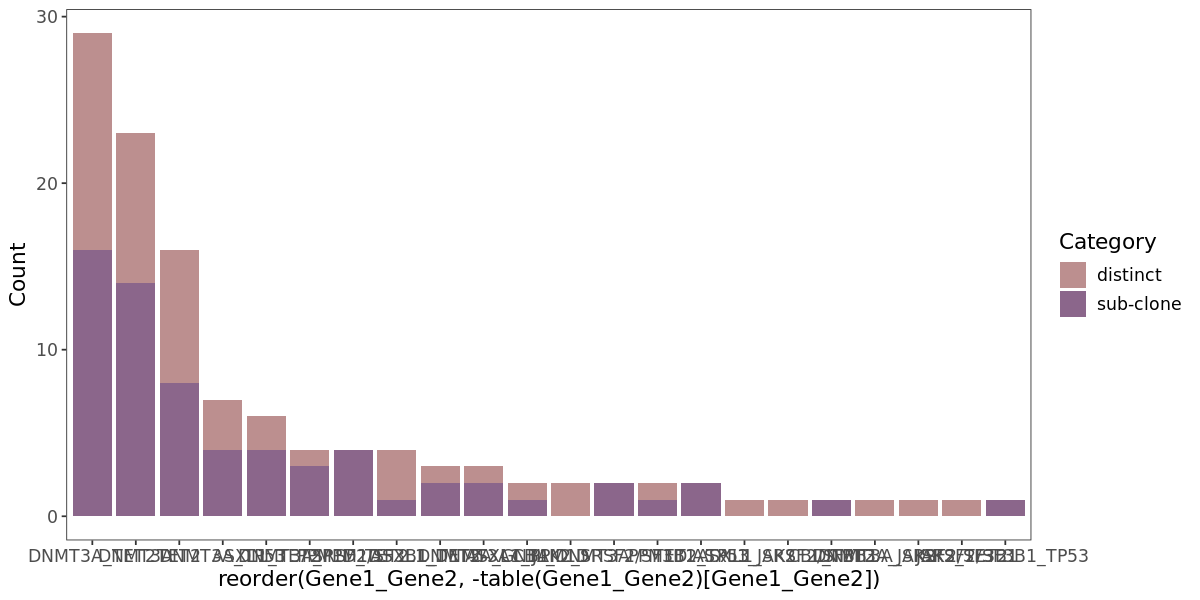

In [57]:
#creating a stacked barplot for the top portion of the upset plot 

# Order values alphabetically by group
categories <- categories %>%
arrange(GRID, Gene)

categories <- categories %>%
group_by(GRID, Category) %>%
summarise(Gene1_Gene2 = paste(unique(Gene), collapse = "_"))

options(repr.plot.width=10, repr.plot.height=5)
h<-ggplot(categories, aes(fill=Category,x=reorder(Gene1_Gene2,-table(Gene1_Gene2)[Gene1_Gene2]))) + 
  geom_bar(position='stack', stat='count')+scale_fill_manual(values=c("rosybrown", "plum4"))+theme_bw()+theme(plot.title = element_text(hjust = 0.5))+ theme(text = element_text(size = 13))+labs(y="Count")+theme(panel.grid.major = element_blank(),
panel.grid.minor = element_blank())
h
ggsave(h, filename = "Category_counts_cooccurence.pdf",height = 5, width = 10)
system("gsutil cp Category_counts_cooccurence.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

In [4]:
library(tidyr)
categories <- two_mut %>%
arrange(GRID, Gene)

categories <- categories %>%
group_by(GRID) %>%
summarise(Gene1_Gene2 = paste(unique(Gene), collapse = "_"))

categories <- separate(categories, Gene1_Gene2, into = c("Gene1", "Gene2"), sep = "_", remove = FALSE)
categories$Gene2 <- ifelse(is.na(categories$Gene2), categories$Gene1, categories$Gene2)

categories <- categories[order(categories$Gene1),]

cooccurance<-categories
cooccurance$sorted_combination <- apply(cooccurance[, c("Gene1", "Gene2")], 1, function(x) toString(sort(x)))

# Count occurrences of each combination
combination_counts <- table(cooccurance$sorted_combination)
                                        
# unique gene combos 
unique_genes <- unique(c(cooccurance$Gene1, cooccurance$Gene2))

#  to store p-values and odds ratios
result_df <- data.frame()

# Perform Fisher's exact test for set of genes
for (i in 1:length(unique_genes)) {
for (j in i:length(unique_genes)) {
gene1 <- unique_genes[i]
gene2 <- unique_genes[j]

# Initialize the 2x2 table with all values set to 1
contingency_table <- matrix(1, nrow = 2, ncol = 2, dimnames = list(c("TRUE", "FALSE"), c("TRUE", "FALSE")))

# Update the table with the actual counts from your data
counts <- table(cooccurance$Gene1 %in% gene1, cooccurance$Gene2 %in% gene2)
contingency_table[1:2, 1:2] <- counts

# Add 1 to each value in the contingency table
contingency_table <- contingency_table + 1

# Perform Fisher's exact test only if the table has at least 2 rows and 2 columns
if (sum(dim(contingency_table) >= 2) == 2) {
fisher_result <- fisher.test(contingency_table)

# Calculate odds ratio
odds_ratio <- fisher_result$estimate

# Add the test results to the data frame
result_df <- rbind(result_df, data.frame(Gene1 = gene1,
Gene2 = gene2,
P_Value = fisher_result$p.value,
Beta = log(odds_ratio),
OR = odds_ratio))
}else {
# Add NA values to the data frame
result_df <- rbind(result_df, data.frame(Gene1 = gene1,
Gene2 = gene2,
P_Value = NA,
Beta = NA,
OR = NA))
}
}
    }

# Print the result data frame
result_df <-result_df[,c("Gene1","Gene2", "OR", "P_Value")]
head(result_df)                                 

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 41 rows [6, 7, 14, 15,
18, 19, 24, 28, 30, 33, 38, 41, 42, 44, 46, 48, 49, 50, 53, 57, ...].”


,Gene1,Gene2,OR,P_Value
,<chr>,<chr>,<dbl>,<dbl>
odds ratio,ASXL1,ASXL1,1.000000,1.00000000
odds ratio1,ASXL1,CBL,1.000000,1.00000000
odds ratio2,ASXL1,DNMT3A,1.103952,1.00000000
odds ratio3,ASXL1,JAK2,7.681459,0.07577268
odds ratio4,ASXL1,PPM1D,3.448340,0.11086607
odds ratio5,ASXL1,SRSF2/SF3B1,3.819153,0.16288889


In [11]:
#add categories for p-value 
cooccurrence_df$logp<- -log(cooccurrence_df$P_Value)
head(cooccurrence_df)

,Gene1,Gene2,OR,P_Value,Sign,Asterisk,logp
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
odds ratio,ASXL1,ASXL1,1.000000,1.00000000,zero,NA,1.110223e-16
odds ratio1,ASXL1,CBL,1.000000,1.00000000,zero,NA,1.110223e-16
odds ratio2,ASXL1,DNMT3A,1.103952,1.00000000,positive,NA,0.000000e+00
odds ratio3,ASXL1,JAK2,7.681459,0.07577268,positive,NA,2.580017e+00
odds ratio4,ASXL1,PPM1D,3.448340,0.11086607,positive,NA,2.199432e+00
odds ratio5,ASXL1,SRSF2/SF3B1,3.819153,0.16288889,positive,NA,1.814687e+00


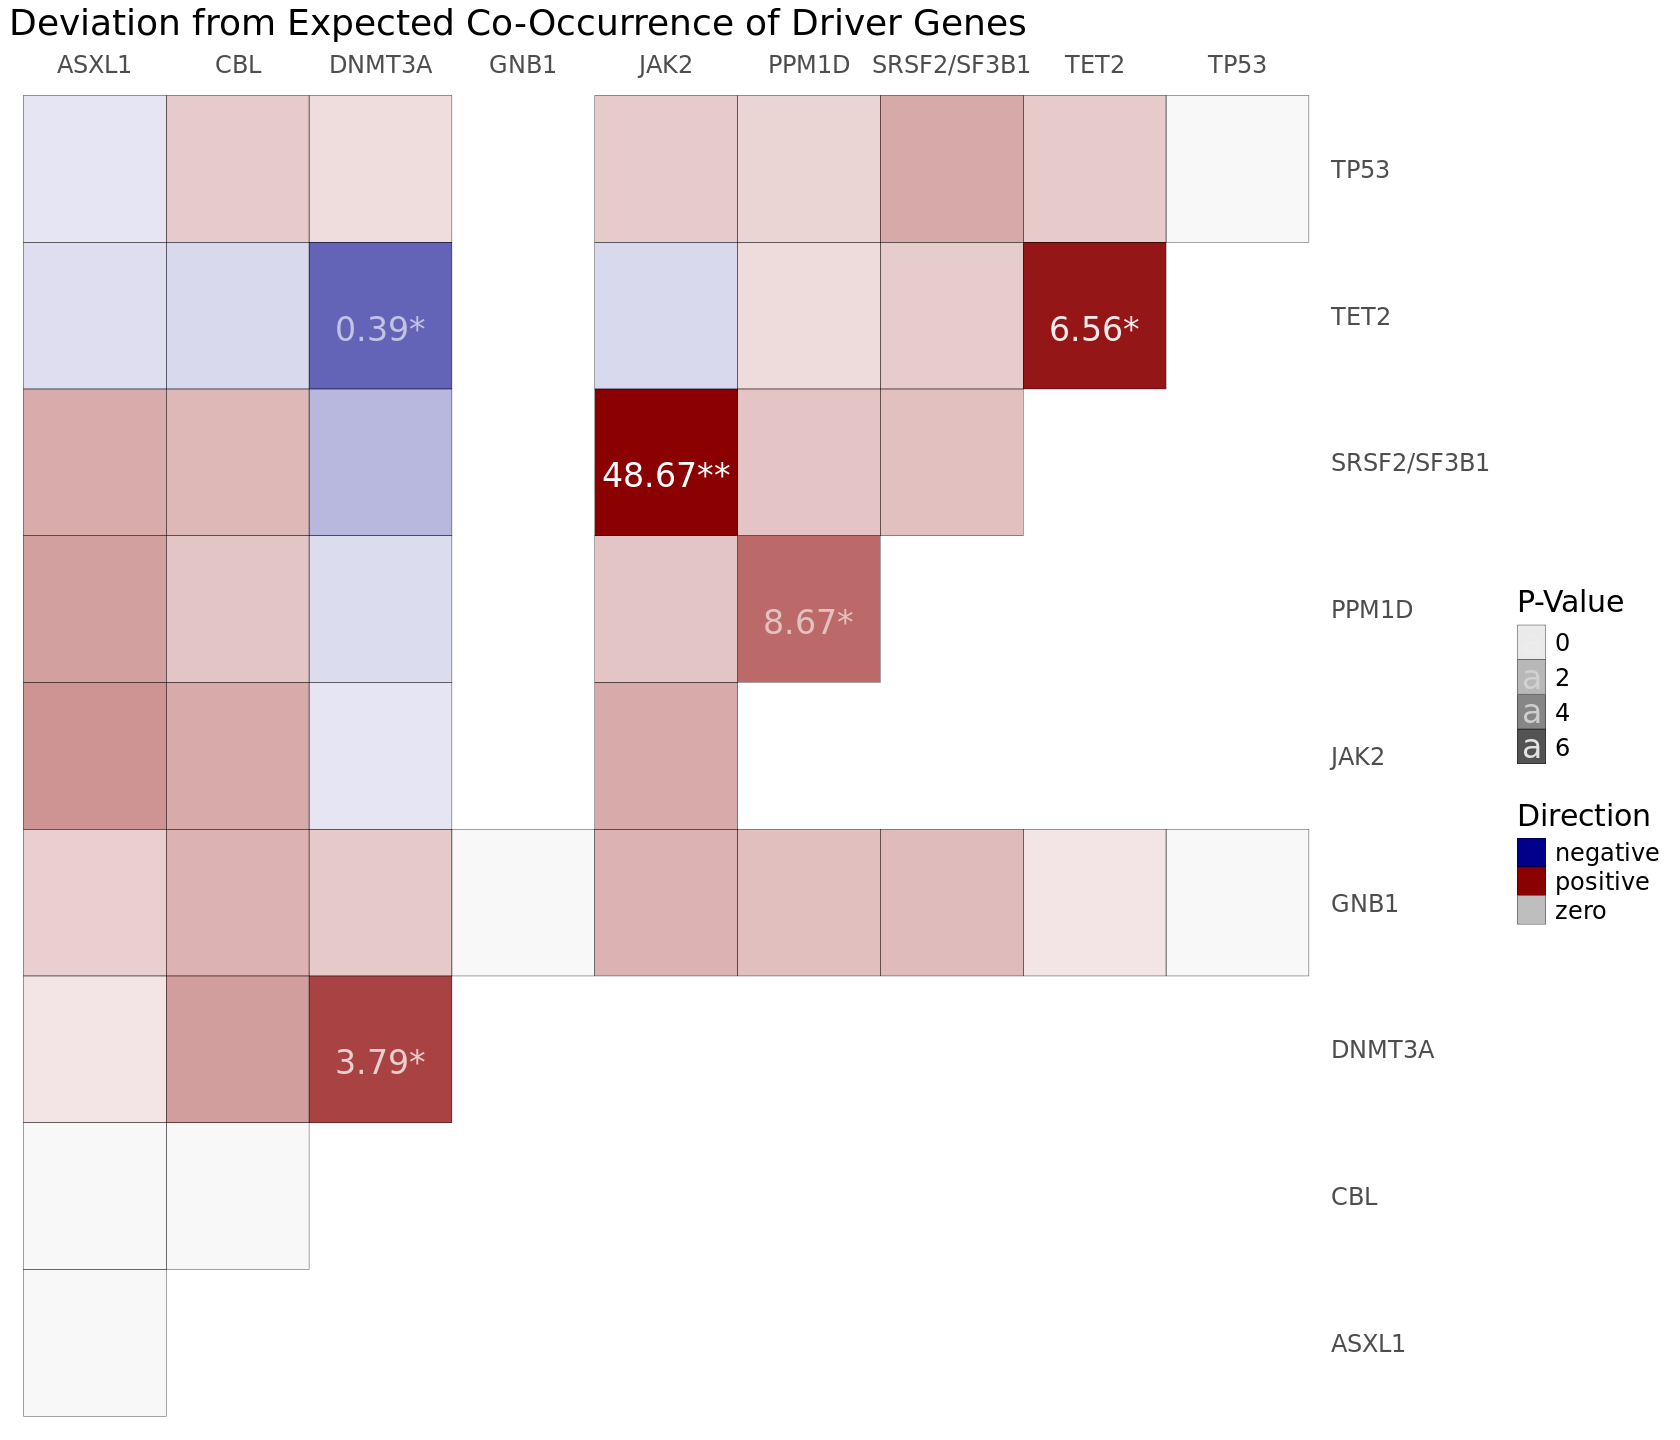

In [21]:
#makes base plot but had to rearrange in Illustrator
options(repr.plot.width=14, repr.plot.height=12)

cooccurrence_df$Sign<-"zero"
cooccurrence_df$Sign[cooccurrence_df$OR > 0 & cooccurrence_df$OR < 1]<- "negative"
cooccurrence_df$Sign[cooccurrence_df$OR > 1]<- "positive"

# Add a column for asterisk based on Freq
cooccurrence_df$Asterisk[cooccurrence_df$P_Value <= 0.05]<- "*"
cooccurrence_df$Asterisk[cooccurrence_df$P_Value <= 0.001]<- "**"

# Plot the heatmap
h<-ggplot(cooccurrence_df, aes(Gene1, Gene2, fill = Sign, alpha =logp)) +
  geom_tile(color = "black") +
  geom_text(data = subset(cooccurrence_df, P_Value < 0.05),aes(label = paste0(sprintf("%.2f", OR), Asterisk)), vjust = 1, size=7, color="white") +  # Add label with asterisk as text
  scale_fill_manual(values = c("positive" = "red4", "negative" = "blue4", "zero"="grey")) +
  scale_alpha_continuous(range = c(0.1, 1)) +
  theme_minimal() +
  labs(title = "Deviation from Expected Co-Occurrence of Driver Genes",
       fill = "Direction",
       alpha = "P-Value") +
  scale_x_discrete(position = "top") + theme(text = element_text(size = 18))+
  scale_y_discrete(position = "right")+theme(axis.title.x = element_blank(), axis.title.y = element_blank(),panel.grid = element_blank())
 h
ggsave(h, filename = "CoOccurence_Plot.pdf",height = 12, width = 14)
system("gsutil cp CoOccurence_Plot.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")

# Figure 4- Cox Prop Hazard 

In [37]:
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/MTP_Dataset_May24.txt .")
data<-fread("MTP_Dataset_May24.txt")

#include fastest growing clone for people with multiple CHIP mutations 
data <-data[data[, .I[which.max(Growth_Rate)], by=GRID]$V1]
head(data)                                                                                                                                                                                    
nrow(data)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,0.001,0.033,55,64,0.032,8.7,0.49465800,expansion,M,W
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,0.023,0.007,77,82,-0.016,5.0,-0.21173174,reduction,F,W
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,0.271,0.348,83,87,0.077,4.0,0.06451672,expansion,M,W
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,0.097,0.090,82,84,-0.007,2.1,-0.03503871,reduction,M,W
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,0.024,0.003,64,72,-0.021,8.2,-0.22399043,reduction,M,W
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,0.020,0.028,66,69,0.008,3.5,0.10090759,expansion,F,W


[1] 711

In [38]:
#converting grids to person_ids 
system("gsutil cp gs://bicklab-main-storage/Data/BioVU/BioVU_GRID_to_personid_conversion.txt .")
grid_conversions <-fread("BioVU_GRID_to_personid_conversion.txt")

#getting the appropriate person_ids for my cohort
individuals <-merge(data, grid_conversions, by="GRID")

id_string <- paste(individuals$person_id, collapse = ", ")

sql <- paste0("
  SELECT *
  FROM `sd-vumc-tanagra-test.terra_sd_20230831.x_codes`
  WHERE person_id IN (", id_string, ")
")

projectid <- "sd-vumc-tanagra-test"
data <- bq_project_query(projectid, sql)
icd_codes <- bq_table_download(data)
head(icd_codes)

icd_only <-subset(icd_codes, vocabulary_id=="ICD10CM"|vocabulary_id=="ICD9CM")
icd_only <-icd_only[,c(1,2,6,7,11)]
colnames(icd_only)<-c("person_id", "ICD_Date","ICD_CODE", "ICD_TYPE", "AgeAtICD")

head(icd_only)

merged<-merge(individuals, icd_only, by="person_id")
head(merged)


person_id,entry_date,entry_datetime,concept_id,concept_name,concept_code,vocabulary_id,visit_occurrence_id,type_concept_id,item_position,age_at_event,x_poa
<int>,<dttm>,<dttm>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
1323796,2022-02-17,2022-02-17,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,97497408,2001443118,OUTPATIENT_POS_2,72,NA
1363367,2022-11-03,2022-11-03,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,111727494,2001443118,OUTPATIENT_POS_53,63,NA
1163565,2022-04-26,2022-04-26,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,98536021,2001443118,OUTPATIENT_POS_11,81,NA
2602608,2022-10-19,2022-10-19,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,112221356,2001443118,OUTPATIENT_POS_44,82,NA
874452,2021-09-17,2021-09-17,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,97586741,2001443118,OUTPATIENT_POS_26,78,NA
2602608,2022-12-23,2022-12-23,700360,"Infectious agent detection by nucleic acid (DNA or RNA); severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) (Coronavirus disease [COVID-19]), amplified probe technique",87635,CPT4,114888909,2001443118,OUTPATIENT_POS_40,82,NA


person_id,ICD_Date,ICD_CODE,ICD_TYPE,AgeAtICD
<int>,<dttm>,<chr>,<chr>,<int>
2219536,2017-06-28,J11.1,ICD10CM,82
2070263,2016-06-07,J11.1,ICD10CM,83
1096435,2017-12-07,J11.1,ICD10CM,77
1245268,2019-10-22,J11.1,ICD10CM,75
781278,2018-06-30,Y09,ICD10CM,40
2719571,2020-01-29,Z20.822,ICD10CM,71


person_id,GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,⋯,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,ICD_Date,ICD_CODE,ICD_TYPE,AgeAtICD
<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<int>
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2020-12-20,Z20.822,ICD10CM,76
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2022-10-03,Z20.822,ICD10CM,78
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2021-09-22,K64.4,ICD10CM,77
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2023-05-10,H02.20A,ICD10CM,78
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2023-05-15,H02.20A,ICD10CM,78
4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,nonsynonymous SNV,1944-06-15,⋯,0.005,10.3,0.01607966,expansion,F,B,2019-08-14,I27.20,ICD10CM,75


In [39]:
#isolating only the last recorded code for each individual to use for censored people

icd_codes<-icd_codes %>% 
  group_by(person_id) %>% 
  slice_max(order_by = entry_date, with_ties = FALSE)
last_date <-icd_codes[,c(1,2)]
colnames(last_date)[2]<-"Last_Record_Date"
nrow(last_date)
head(last_date)

[1] 711

person_id,Last_Record_Date
<int>,<dttm>
4481,2023-08-01
19127,2023-05-07
19252,2019-09-18
19369,2022-01-16
21272,2023-03-11
23772,2023-03-09


In [40]:
# convert to phecodes 
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/phecode_icd10.csv .")
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/PheWAS/phecode_icd9_rolled.csv .")
icd_10<-fread("phecode_icd10.csv")
icd_9<-fread("phecode_icd9_rolled.csv")

colnames(icd_10)[1]<-"ICD_CODE"
colnames(icd_10)[2]<-"ICD_Desc"
icd_10<-icd_10[,c(1:4)]

colnames(icd_9)[1]<-"ICD_CODE"
colnames(icd_9)[2]<-"ICD_Desc"
icd_9<-icd_9[,c(1:4)]

icd_conversion <-rbind(icd_9, icd_10)

icd_merged<-merge(merged, icd_conversion, by="ICD_CODE")


In [41]:
#generalizing down to whole number code 
icd_merged$PheCode <-as.numeric(icd_merged$PheCode)
icd_merged$PheCode_cat <-floor(icd_merged$PheCode)
icd_merged$PheCode_cat<-as.character(icd_merged$PheCode_cat)
head(icd_merged)

#merging with more general phenotype description 
icd_conversion <-icd_conversion[,c(3:4)]
colnames(icd_conversion)<-c("PheCode_cat", "Phenotype_cat")
icd_conversion$PheCode_cat<-as.character(icd_conversion$PheCode_cat)
head(icd_conversion)

icd_merged_cat <-merge(icd_merged, icd_conversion, by="PheCode_cat",allow.cartesian=TRUE)

head(icd_merged_cat)

ICD_CODE,person_id,GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,⋯,direction,Sex,Race,ICD_Date,ICD_TYPE,AgeAtICD,ICD_Desc,PheCode,Phenotype,PheCode_cat
<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dttm>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>
003.1,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-08-03,ICD9CM,67,Salmonella septicemia,38.1,Gram negative septicemia,38
003.1,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-08-05,ICD9CM,67,Salmonella septicemia,38.1,Gram negative septicemia,38
003.1,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-08-01,ICD9CM,67,Salmonella septicemia,38.1,Gram negative septicemia,38
003.1,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-07-29,ICD9CM,67,Salmonella septicemia,38.1,Gram negative septicemia,38
003.1,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-08-02,ICD9CM,67,Salmonella septicemia,38.1,Gram negative septicemia,38
003.9,1316310,R204489375,DNMT3A,chr2,25241650,25241650,A,C,nonsynonymous SNV,⋯,reduction,F,B,2010-08-06,ICD9CM,67,Salmonella infection NOS,8.5,Bacterial enteritis,8


PheCode_cat,Phenotype_cat
<chr>,<chr>
8,Intestinal infection
8,Intestinal infection
8,Intestinal infection
8,Intestinal infection
8,Intestinal infection
8.5,Bacterial enteritis


PheCode_cat,ICD_CODE,person_id,GRID,Gene,Chr,Start,End,Ref,Alt,⋯,direction,Sex,Race,ICD_Date,ICD_TYPE,AgeAtICD,ICD_Desc,PheCode,Phenotype,Phenotype_cat
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dttm>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,
NA,F32.0,4481,R280968977,DNMT3A,chr2,25234373,25234373,C,T,⋯,expansion,F,B,2020-05-19,ICD10CM,75,Mild depressive episode,NA,,


In [42]:
#only keep phecodes that occur at least twice and isolate the first instance of this phecode 
icd_merged_cat<-icd_merged_cat %>% 
  group_by(person_id, PheCode_cat) %>% 
    filter(n() >=2) %>%
  slice_min(order_by = ICD_Date, with_ties = FALSE)

library(lubridate)
icd_merged$ICD_Date <-as.Date(ymd(icd_merged$ICD_Date))

#keep only the phecodes that first appeared after TP2
icd_merged_cat2 <-subset(icd_merged_cat, DATE_B < ICD_Date)

length(unique(icd_merged_cat$PheCode))
length(unique(icd_merged_cat$person_id))

length(unique(icd_merged_cat2$PheCode))

[1] 1559

[1] 711

[1] 1011

In [44]:
# rank inverse normal transform the data 
icd_merged_cat2$Growth_Rate_raw<-icd_merged_cat2$Growth_Rate

ranks <- rank(icd_merged_cat2$Growth_Rate)

# Compute the z-scores
z_scores <- qnorm((ranks - 0.5) / length(icd_merged_cat2$Growth_Rate))

# Replace the original data with the transformed z-scores
icd_merged_cat2$Growth_Rate <- z_scores

#calculate time to event
survival_data <-icd_merged_cat2[,c("person_id", "AgeAtICD", "Gene","DATE_A", "DATE_B", "Age_A", "Age_B","AF_B", "direction", "Growth_Rate","Growth_Rate_raw","PheCode_cat","Phenotype_cat", "Sex", "Race","ICD_Date")]

#subset to codes that occur at least 20 times
count <-as.data.frame(table(survival_data$PheCode_cat))
colnames(count)[1]<-"PheCode_cat"

survival_data<-merge(survival_data, count, by="PheCode_cat")
survival_data<-subset(survival_data, Freq>=20)

In [45]:
# Count the number of people with each PheCode_cat
phecode_counts <- survival_data %>%
  group_by(PheCode_cat) %>%
  summarise(Count = n_distinct(person_id))
# Get unique Phecodes
unique_phecodes <- unique(survival_data$PheCode_cat)

# Create an empty list to store model results
cox_models <- list()

# Initiate empty results df 
results_df <- data.frame(
  Phecode = character(), 
  Beta = numeric(), 
  Std_Error = numeric(), 
  P_Value = numeric(), 
  CI_Lower = numeric(), 
  CI_Upper = numeric(), 
  Count = integer(), 
  stringsAsFactors = FALSE
)

# Loop through each unique Phecode
for (phecode in unique_phecodes) {
  # Subset people who have that phecode
  yes_phecode <- survival_data[survival_data$PheCode_cat == phecode, ]

  # Subset people who don't have the code (censored) and subset to one row per individual
  no_phecode <- anti_join(survival_data, yes_phecode, by = "person_id")
  no_phecode <- no_phecode[!duplicated(no_phecode$person_id), ]

  # Add column for presence/absence of phecode 
  yes_phecode$phecode_present <- "1"
  no_phecode$phecode_present <- "0"
  no_phecode$PheCode_cat <- phecode

  # Change date to last date on record for people without phecode
  matching_ids <- no_phecode$person_id %in% last_date$person_id
  no_phecode$ICD_Date[matching_ids] <- last_date$Last_Record_Date[match(no_phecode$person_id[matching_ids], last_date$person_id)]

  # Combine datasets to have whole cohort
  combined <- rbind(yes_phecode, no_phecode)

  combined$time_to_event <- as.numeric(interval(combined$DATE_B, combined$ICD_Date) %/% months(1))
  combined$time_to_event <- as.numeric(combined$time_to_event)
  combined$phecode_present <- as.numeric(combined$phecode_present)

  survival <- with(combined, Surv(time_to_event, phecode_present))
  cox_model <- coxph(survival ~ Growth_Rate + Age_B + AF_B + Sex, data = combined)

  summary_model <- summary(cox_model)

  # Extract summary stats for Growth_Rate
  beta_growth_rate <- summary_model$coef["Growth_Rate", "coef"]
  std_error_growth_rate <- summary_model$coef["Growth_Rate", "se(coef)"]
  p_value_growth_rate <- summary_model$coef["Growth_Rate", "Pr(>|z|)"]
  ci_lower<- beta_growth_rate - 1.96 * std_error_growth_rate
ci_upper <- beta_growth_rate + 1.96 * std_error_growth_rate
  count <- nrow(yes_phecode)

  phecode_results <- data.frame(
    Phecode = phecode, 
    Beta = beta_growth_rate, 
    Std_Error = std_error_growth_rate, 
    P_Value = p_value_growth_rate, 
    CI_Lower = ci_lower, 
    CI_Upper = ci_upper, 
    Count = count
  )
  results_df <- rbind(results_df, phecode_results)
}

# Merge conversion table
conversion <- survival_data %>%
  select(PheCode_cat, Phenotype_cat) %>%
  distinct()
colnames(conversion)[1] <- "Phecode"

results_df <- merge(results_df, conversion, by = "Phecode")

# Merge with phecode counts (this step might not be necessary as we already added the count)
# colnames(phecode_counts)[1] <- "Phecode"
# results_df <- merge(results_df, phecode_counts, by = "Phecode")

# Sort results by p-value
sorted_results_df <- results_df[order(results_df$P_Value), ]
head(sorted_results_df, 30)



Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



,Phecode,Beta,Std_Error,P_Value,CI_Lower,CI_Upper,Count,Phenotype_cat
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
7,200,0.5073699,0.2102660,0.01582222,0.09524855,0.919491241,23,Myeloproliferative disease
15,251,-0.4938950,0.2234373,0.02707460,-0.93183217,-0.055957775,22,Other disorders of pancreatic internal secretion
100,586,0.2398299,0.1099564,0.02917338,0.02431529,0.455344440,79,Other disorders of the kidney and ureters
10,241,0.3925135,0.1811767,0.03027541,0.03740725,0.747619728,27,Nontoxic nodular goiter
124,761,-0.2799548,0.1386884,0.04353006,-0.55178409,-0.008125476,54,Cervicalgia
127,783,-0.2213686,0.1156387,0.05558013,-0.44802043,0.005283144,69,Fever of unknown origin
115,716,-0.2600833,0.1416221,0.06628968,-0.53766258,0.017496017,51,Other arthropathies
136,939,-0.2898812,0.1713417,0.09067821,-0.62571092,0.045948545,35,Atopic/contact dermatitis due to other or unspecified
107,690,-0.3292857,0.1983297,0.09685518,-0.71801191,0.059440458,26,Erythematosquamous dermatosis


In [46]:
#write a df of all the codes that are included here
write.table(sorted_results_df, "Cox_Prop_Hazard_Results_postTP2.txt", col.names=T, row.names=F, sep="\t", quote=F)
system("gsutil cp Cox_Prop_Hazard_Results_postTP2.txt gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/MTP/Cox_Prop_Hazard/")

In [47]:
#valvular heart disease

yes_phecode <- subset(survival_data, PheCode_cat=="394"|PheCode_cat=="395")
no_phecode <- anti_join(survival_data, yes_phecode, by = "person_id")
  no_phecode <- no_phecode[!duplicated(no_phecode$person_id), ]

  yes_phecode$phecode_present <- "1"
  no_phecode$phecode_present <- "0"
  no_phecode$PheCode_cat <- "394_395"

 # Change date to last date on record for people without phecode
  matching_ids <- no_phecode$person_id %in% last_date$person_id
  no_phecode$ICD_Date[matching_ids] <- last_date$Last_Record_Date[match(no_phecode$person_id[matching_ids], last_date$person_id)]

  # Combine datasets to have whole cohort
  combined <- rbind(yes_phecode, no_phecode)

  combined$time_to_event <- as.numeric(interval(combined$DATE_B, combined$ICD_Date) %/% months(1))
  combined$time_to_event <- as.numeric(combined$time_to_event)
  combined$phecode_present <- as.numeric(combined$phecode_present)

  survival <- with(combined, Surv(time_to_event, phecode_present))
  cox_model <- coxph(survival ~ Growth_Rate + Age_B + AF_B + Sex, data = combined)

  summary_model <- summary(cox_model)

 beta_growth_rate <- summary_model$coef["Growth_Rate", "coef"]
  std_error_growth_rate <- summary_model$coef["Growth_Rate", "se(coef)"]
  p_value_growth_rate <- summary_model$coef["Growth_Rate", "Pr(>|z|)"]
  ci_lower<- beta_growth_rate - 1.96 * std_error_growth_rate
ci_upper <- beta_growth_rate + 1.96 * std_error_growth_rate
  count <- nrow(yes_phecode)

  phecode_results <- data.frame(
    Phecode = "394_395", 
    Beta = beta_growth_rate, 
    Std_Error = std_error_growth_rate, 
    P_Value = p_value_growth_rate, 
    CI_Lower = ci_lower, 
    CI_Upper = ci_upper, 
    Count = count
  )

phecode_results

Phecode,Beta,Std_Error,P_Value,CI_Lower,CI_Upper,Count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
394_395,-0.002396067,0.07127484,0.9731823,-0.1420947,0.1373026,209


In [48]:
#athlerosclerosis/CAD

yes_phecode <- subset(survival_data, PheCode_cat=="411"|PheCode_cat=="412"|PheCode_cat=="413"|PheCode_cat=="414"|PheCode_cat=="440")
no_phecode <- anti_join(survival_data, yes_phecode, by = "person_id")
  no_phecode <- no_phecode[!duplicated(no_phecode$person_id), ]

  yes_phecode$phecode_present <- "1"
  no_phecode$phecode_present <- "0"
  no_phecode$PheCode_cat <- "ath_cad"

 # Change date to last date on record for people without phecode
  matching_ids <- no_phecode$person_id %in% last_date$person_id
  no_phecode$ICD_Date[matching_ids] <- last_date$Last_Record_Date[match(no_phecode$person_id[matching_ids], last_date$person_id)]

  # Combine datasets to have whole cohort
  combined <- rbind(yes_phecode, no_phecode)

  combined$time_to_event <- as.numeric(interval(combined$DATE_B, combined$ICD_Date) %/% months(1))
  combined$time_to_event <- as.numeric(combined$time_to_event)
  combined$phecode_present <- as.numeric(combined$phecode_present)

  survival <- with(combined, Surv(time_to_event, phecode_present))
  cox_model <- coxph(survival ~ Growth_Rate + Age_B + AF_B + Sex, data = combined)

  summary_model <- summary(cox_model)

 beta_growth_rate <- summary_model$coef["Growth_Rate", "coef"]
  std_error_growth_rate <- summary_model$coef["Growth_Rate", "se(coef)"]
  p_value_growth_rate <- summary_model$coef["Growth_Rate", "Pr(>|z|)"]
  ci_lower <- beta_growth_rate - 1.96 * std_error_growth_rate
ci_upper <- beta_growth_rate + 1.96 * std_error_growth_rate
  count <- nrow(yes_phecode)

  phecode_results <- data.frame(
    Phecode = "ath_cad", 
    Beta = beta_growth_rate, 
    Std_Error = std_error_growth_rate, 
    P_Value = p_value_growth_rate, 
    CI_Lower = ci_lower, 
    CI_Upper = ci_upper, 
    Count = count
  )

phecode_results

Phecode,Beta,Std_Error,P_Value,CI_Lower,CI_Upper,Count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
ath_cad,0.1428078,0.08567031,0.09552502,-0.02510598,0.3107216,145


In [49]:
#arrythmia

yes_phecode <- subset(survival_data, PheCode_cat=="426"|PheCode_cat=="427")
no_phecode <- anti_join(survival_data, yes_phecode, by = "person_id")
  no_phecode <- no_phecode[!duplicated(no_phecode$person_id), ]

  yes_phecode$phecode_present <- "1"
  no_phecode$phecode_present <- "0"
  no_phecode$PheCode_cat <- "arrythmia"

 # Change date to last date on record for people without phecode
  matching_ids <- no_phecode$person_id %in% last_date$person_id
  no_phecode$ICD_Date[matching_ids] <- last_date$Last_Record_Date[match(no_phecode$person_id[matching_ids], last_date$person_id)]

  # Combine datasets to have whole cohort
  combined <- rbind(yes_phecode, no_phecode)

  combined$time_to_event <- as.numeric(interval(combined$DATE_B, combined$ICD_Date) %/% months(1))
  combined$time_to_event <- as.numeric(combined$time_to_event)
  combined$phecode_present <- as.numeric(combined$phecode_present)

  survival <- with(combined, Surv(time_to_event, phecode_present))
  cox_model <- coxph(survival ~ Growth_Rate + Age_B + AF_B + Sex, data = combined)

  summary_model <- summary(cox_model)

 beta_growth_rate <- summary_model$coef["Growth_Rate", "coef"]
  std_error_growth_rate <- summary_model$coef["Growth_Rate", "se(coef)"]
  p_value_growth_rate <- summary_model$coef["Growth_Rate", "Pr(>|z|)"]
  ci_lower <- beta_growth_rate - 1.96 * std_error_growth_rate
ci_upper <- beta_growth_rate + 1.96 * std_error_growth_rate
  count <- nrow(yes_phecode)

  phecode_results <- data.frame(
    Phecode = "arrythmia", 
    Beta = beta_growth_rate, 
    Std_Error = std_error_growth_rate, 
    P_Value = p_value_growth_rate, 
    CI_Lower = ci_lower, 
    CI_Upper = ci_upper, 
    Count = count
  )

phecode_results

Phecode,Beta,Std_Error,P_Value,CI_Lower,CI_Upper,Count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
arrythmia,0.07652982,0.08834637,0.3863544,-0.09662906,0.2496887,135


## Death Outcome  

In [2]:
#bringing in death date for individuals marked as deceased in the EHR
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/Death_Dates_MTP.csv .")
death_dates<- fread("Death_Dates_MTP.csv")
death_dates$Date <-as.Date(mdy(death_dates$Date))
death_dates$Deceased <-"1"
head(death_dates)

GRID,Deceased,Date
<chr>,<chr>,<date>
R200198059,1,2020-04-25
R200420336,1,2019-11-12
R201153055,1,2022-03-20
R203066878,1,2017-03-08
R203125048,1,2022-10-04
R204489375,1,2019-12-29


In [3]:
#isolate individuals that do not have death dates 
system("gsutil cp gs://bicklab-main-storage/Users/Taralynn_Mack/BioVU_MTP_Project/Full_Dataset/MTP_Dataset_May24.txt .")
data<-fread("MTP_Dataset_May24.txt")

alive<-anti_join(data, death_dates, by="GRID")
nrow(alive)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 764

In [4]:
#getting person_id for these individuals 
system("gsutil cp gs://bicklab-main-storage/Data/BioVU/BioVU_GRID_to_personid_conversion.txt .")
grid_conversions <-fread("BioVU_GRID_to_personid_conversion.txt")

individuals <-merge(alive, grid_conversions, by="GRID")
individuals <-distinct(individuals, person_id, .keep_all = TRUE)
head(individuals)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,person_id
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,0.033,55,64,0.032,8.7,0.49465800,expansion,M,W,2240791
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,0.348,83,87,0.077,4.0,0.06451672,expansion,M,W,1589089
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,0.090,82,84,-0.007,2.1,-0.03503871,reduction,M,W,189378
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,0.028,66,69,0.008,3.5,0.10090759,expansion,F,W,1533282
R200779674,TET2,chr4,105243621,105243621,C,T,stopgain,1926-02-07,9700-AB-1566,⋯,0.024,81,90,-0.016,9.4,-0.05289295,reduction,F,W,396530
R200939833,DNMT3A,chr2,25240315,25240315,G,A,nonsynonymous SNV,1933-12-25,9700-AB-0762,⋯,0.097,77,81,-0.009,3.9,-0.02249395,reduction,F,W,666733


In [8]:
#pulling all the codes for the individuals

id_string <- paste(individuals$person_id, collapse = ", ")

sql <- paste0("
  SELECT *
  FROM `sd-vumc-tanagra-test.terra_sd_20230831.x_codes`
  WHERE person_id IN (", id_string, ")
")

projectid <- "sd-vumc-tanagra-test"
data <- bq_project_query(projectid, sql)
concept_codes <- bq_table_download(data)
head(concept_codes)

ERROR: Error in eval(expr, envir, enclos): 920383 rows were requested, but only 917344 rows were received.
  Leave `page_size` unspecified or use an even smaller value.


In [9]:
# split the individuals$person_id vector into two halves
half <- length(individuals$person_id) %/% 2

# create two vectors
ids1 <- individuals$person_id[1:half]
ids2 <- individuals$person_id[(half+1):length(individuals$person_id)]

# create two ID strings
id_string1 <- paste(ids1, collapse = ", ")
id_string2 <- paste(ids2, collapse = ", ")

# create two SQL queries
sql1 <- paste0("
SELECT *
FROM `sd-vumc-tanagra-test.terra_sd_20230831.x_codes`
WHERE person_id IN (", id_string1, ")
")

sql2 <- paste0("
SELECT *
FROM `sd-vumc-tanagra-test.terra_sd_20230831.x_codes`
WHERE person_id IN (", id_string2, ")
")

# run the two queries
projectid <- "sd-vumc-tanagra-test"

data1 <- bq_project_query(projectid, sql1)
data2 <- bq_project_query(projectid, sql2)

# download the results
concept_codes1 <- bq_table_download(data1)
concept_codes2 <- bq_table_download(data2)

# combine the two result dataframes
concept_codes <- rbind(concept_codes1, concept_codes2)

head(concept_codes)


person_id,entry_date,entry_datetime,concept_id,concept_name,concept_code,vocabulary_id,visit_occurrence_id,type_concept_id,item_position,age_at_event,x_poa
<int>,<dttm>,<dttm>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
755932,2021-06-18,2021-06-18,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,93525007,2001443118,OUTPATIENT_POS_2,40,NA
2053373,2021-09-05,2021-09-05,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,93693988,2001443118,OUTPATIENT_POS_1,63,NA
433075,2020-12-31,2020-12-31,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,90852527,2001443118,OUTPATIENT_POS_4,69,NA
2340887,2020-01-12,2020-01-12,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,87766758,2001443118,OUTPATIENT_POS_2,69,NA
505769,2021-01-11,2021-01-11,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,93536419,2001443118,OUTPATIENT_POS_1,70,NA
947347,2019-09-01,2019-09-01,704058,"2019-nCoV Coronavirus, SARS-CoV-2/2019-nCoV (COVID-19), any technique, multiple types or subtypes (includes all targets), non-CDC, making use of high throughput technologies as described by CMS-2020-01-R",U0004,HCPCS,87894859,2001443118,OUTPATIENT_POS_2,70,NA


In [10]:
#isolating only the last recorded code for each individual 
nrow(concept_codes)
concept_codes<-concept_codes %>% 
  group_by(person_id) %>% 
  slice_max(order_by = entry_date, with_ties = FALSE)
nrow(concept_codes)

[1] 920383

[1] 612

In [11]:
concept_codes<-concept_codes[,c(1,2)]
alive <-merge(concept_codes, grid_conversions, by="person_id")
alive$Deceased <-"0"
alive <-alive[,c(3,4,2)]
colnames(alive)<-c("GRID", "Deceased", "Date")
alive$Date <-as.Date(ymd(alive$Date))
head(alive)

,GRID,Deceased,Date
,<chr>,<chr>,<date>
1,R280968977,0,2023-08-01
2,R259494883,0,2023-05-07
3,R291292894,0,2022-01-16
4,R253820109,0,2023-03-11
5,R208876101,0,2023-03-09
6,R234863227,0,2015-01-31


In [12]:
#combine datasets 
dataset<-rbind(alive, death_dates)
dataset<-distinct(dataset, GRID, .keep_all = TRUE)
head(dataset)
nrow(dataset)

,GRID,Deceased,Date
,<chr>,<chr>,<date>
1,R280968977,0,2023-08-01
2,R259494883,0,2023-05-07
3,R291292894,0,2022-01-16
4,R253820109,0,2023-03-11
5,R208876101,0,2023-03-09
6,R234863227,0,2015-01-31


[1] 711

In [13]:
table(dataset$Deceased)


  0   1 
612  99 

In [109]:
data<-fread("MTP_Dataset_May24.txt")
data <-data[data[, .I[which.max(Growth_Rate)], by=GRID]$V1]
everything<-merge(data, dataset, by="GRID")
everything$Deceased <-as.numeric(everything$Deceased)
head(everything)
nrow(everything)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,Deceased,Date
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<date>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,55,64,0.032,8.7,0.49465800,expansion,M,W,0,2023-02-18
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,77,82,-0.016,5.0,-0.21173174,reduction,F,W,1,2020-04-25
R200376251,SF3B1,chr2,197402757,197402757,T,C,nonsynonymous SNV,1927-10-07,9700-AB-5035,⋯,83,87,0.077,4.0,0.06451672,expansion,M,W,0,2015-12-08
R200403009,GNAS,chr20,58909366,58909366,G,A,nonsynonymous SNV,1930-09-19,9700-AB-0782,⋯,82,84,-0.007,2.1,-0.03503871,reduction,M,W,0,2014-12-12
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,64,72,-0.021,8.2,-0.22399043,reduction,M,W,1,2019-11-12
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,66,69,0.008,3.5,0.10090759,expansion,F,W,0,2023-02-01


[1] 711

In [110]:
everything <-
  everything %>% 
  mutate(
    survival_time = as.duration(DATE_B %--% Date) / dyears(1)
    )
everything<-subset(everything, survival_time>1)
head(everything)
nrow(everything)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,Deceased,Date,survival_time
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,64,0.032,8.7,0.49465800,expansion,M,W,0,2023-02-18,5.152635
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,82,-0.016,5.0,-0.21173174,reduction,F,W,1,2020-04-25,3.159480
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,72,-0.021,8.2,-0.22399043,reduction,M,W,1,2019-11-12,3.017112
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,69,0.008,3.5,0.10090759,expansion,F,W,0,2023-02-01,4.870637
R200939833,DNMT3A,chr2,25240315,25240315,G,A,nonsynonymous SNV,1933-12-25,9700-AB-0762,⋯,81,-0.009,3.9,-0.02249395,reduction,F,W,0,2022-01-09,6.940452
R201059668,TP53,chr17,7675175,7675175,C,A,nonsynonymous SNV,1946-05-27,9700-AB-2072,⋯,68,0.020,5.5,0.73941619,expansion,F,W,0,2022-05-26,7.646817


[1] 587

In [111]:
Surv(everything$survival_time, everything$Deceased)[1:10]

 [1]  5.152635+  3.159480   3.017112   4.870637+  6.940452+  7.646817+
 [7]  4.312115+  6.176591+ 11.449692   9.190965+

In [112]:
everything$survival_time<-as.numeric(everything$survival_time)
survival = Surv(everything$survival_time,everything$Deceased)

In [113]:
# rank inverse normal transform the data 

ranks <- rank(everything$Growth_Rate)

# Compute the z-scores
z_scores <- qnorm((ranks - 0.5) / length(everything$Growth_Rate))

# Replace the original data with the transformed z-scores
everything$Growth_Rate <- z_scores
head(everything)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,Deceased,Date,survival_time
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<date>,<dbl>
R200115546,TET2,chr4,105236265,105236265,AT,A,frameshift deletion,1953-09-09,7493-AB-092,⋯,64,0.032,8.7,1.6261477,expansion,M,W,0,2023-02-18,5.152635
R200198059,DNMT3A,chr2,25234380,25234380,T,C,nonsynonymous SNV,1934-08-16,9700-AB-3966,⋯,82,-0.016,5.0,-1.9650906,reduction,F,W,1,2020-04-25,3.159480
R200420336,DNMT3A,chr2,25239128,25239128,A,G,splicing,1943-12-09,9700-AB-1362,⋯,72,-0.021,8.2,-2.0622674,reduction,M,W,1,2019-11-12,3.017112
R200751502,DNMT3A,chr2,25248061,25248061,T,-,frameshift deletion,1948-06-28,9700-AB-3431,⋯,69,0.008,3.5,0.2502617,expansion,F,W,0,2023-02-01,4.870637
R200939833,DNMT3A,chr2,25240315,25240315,G,A,nonsynonymous SNV,1933-12-25,9700-AB-0762,⋯,81,-0.009,3.9,-1.0044498,reduction,F,W,0,2022-01-09,6.940452
R201059668,TP53,chr17,7675175,7675175,C,A,nonsynonymous SNV,1946-05-27,9700-AB-2072,⋯,68,0.020,5.5,1.9093415,expansion,F,W,0,2022-05-26,7.646817


In [115]:
cox_model <- coxph(survival ~ Growth_Rate + Age_B + AF_B + Sex, data = everything)

  summary_model <- summary(cox_model)
summary_model
 beta_growth_rate <- summary_model$coef["Growth_Rate", "coef"]
  std_error_growth_rate <- summary_model$coef["Growth_Rate", "se(coef)"]
  p_value_growth_rate <- summary_model$coef["Growth_Rate", "Pr(>|z|)"]
  ci_lower_beta <- beta_growth_rate - 1.96 * std_error_growth_rate
ci_upper_beta <- beta_growth_rate + 1.96 * std_error_growth_rate
 
  phecode_results <- data.frame(
    Phecode = "death", 
    Beta = beta_growth_rate, 
    Std_Error = std_error_growth_rate, 
    P_Value = p_value_growth_rate, 
    CI_Lower = ci_lower_beta, 
    CI_Upper = ci_upper_beta 
  )
phecode_results

Call:
coxph(formula = survival ~ Growth_Rate + Age_B + AF_B + Sex, 
    data = everything)

  n= 587, number of events= 68 

                coef exp(coef) se(coef)      z Pr(>|z|)    
Growth_Rate -0.02642   0.97393  0.12296 -0.215 0.829867    
Age_B        0.06396   1.06605  0.01931  3.313 0.000924 ***
AF_B        -2.47740   0.08396  1.63360 -1.517 0.129386    
SexM         0.21052   1.23431  0.24806  0.849 0.396073    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
Growth_Rate   0.97393     1.0268  0.765355     1.239
Age_B         1.06605     0.9380  1.026462     1.107
AF_B          0.08396    11.9103  0.003416     2.063
SexM          1.23431     0.8102  0.759065     2.007

Concordance= 0.638  (se = 0.036 )
Likelihood ratio test= 15.47  on 4 df,   p=0.004
Wald test            = 13.92  on 4 df,   p=0.008
Score (logrank) test = 13.58  on 4 df,   p=0.009


Phecode,Beta,Std_Error,P_Value,CI_Lower,CI_Upper
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
death,-0.0264205,0.1229591,0.8298669,-0.2674204,0.2145794


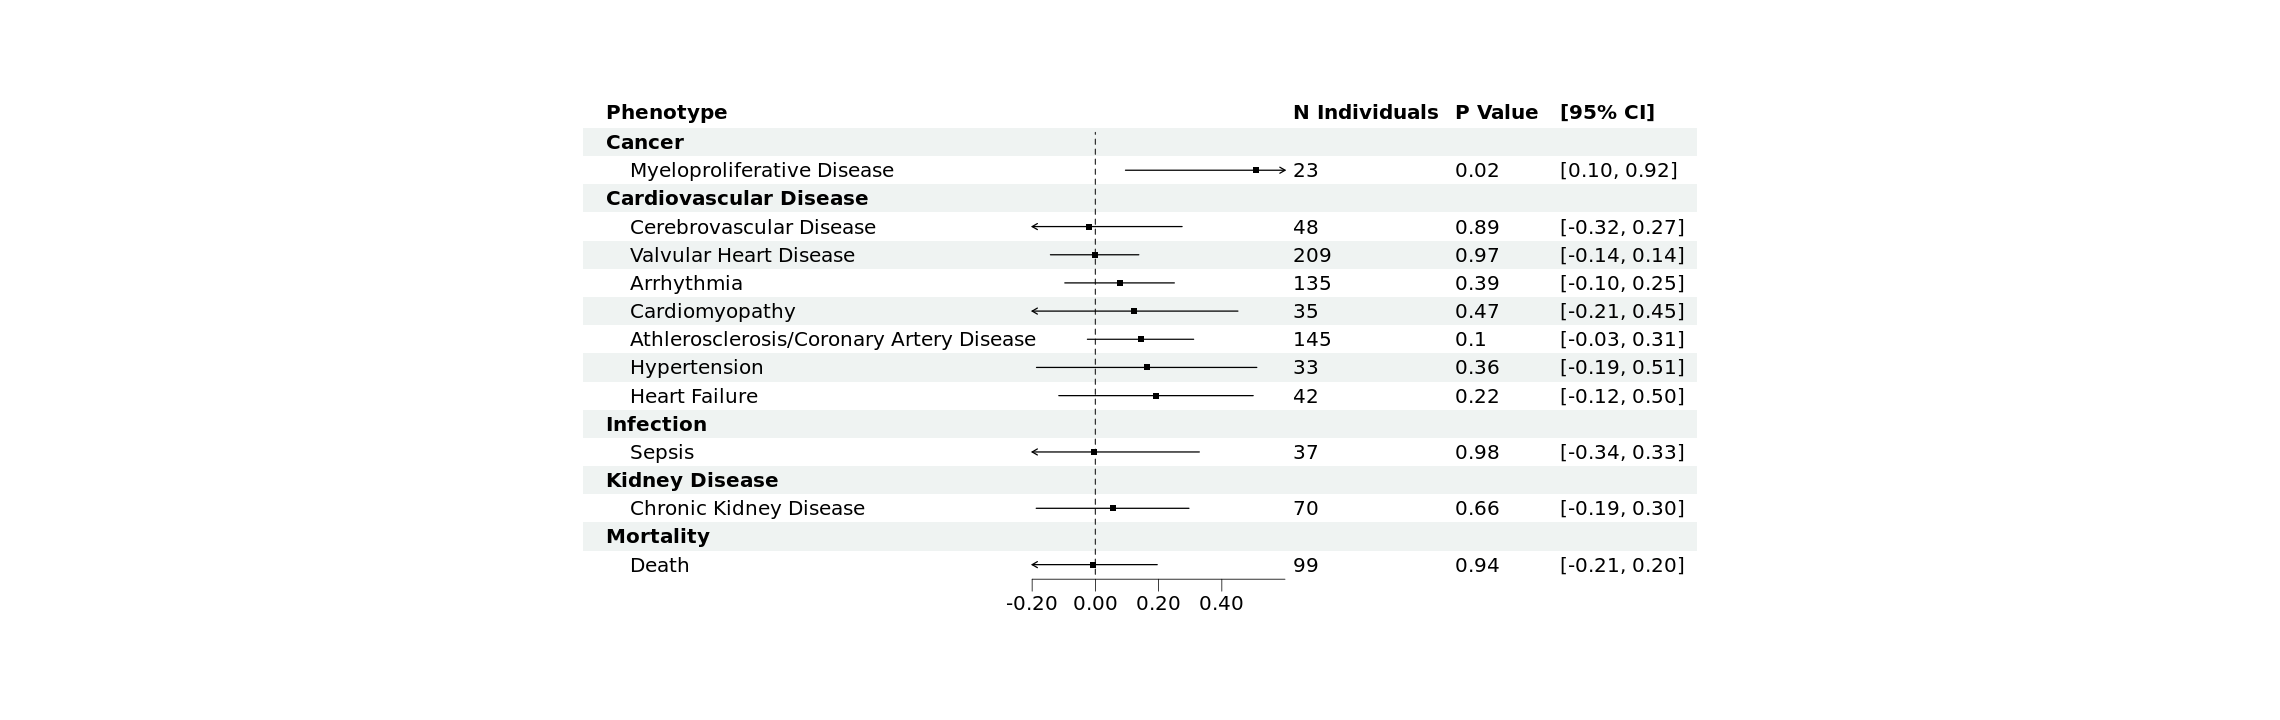

In [89]:
# system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/MTP/Cox_Prop_Hazard/Cox_Prop_Hazard_Results_Regression.txt .")
options(repr.plot.width=19, repr.plot.height=6)
results <-fread("Cox_Prop_Hazard_Results_Regression.txt")
# install.packages("forestploter")
# library(forestploter)

results$''<-paste(rep(" ", 20), collapse=" ")
results$`[95% CI]` <- ifelse(is.na(results$StdError), "",
                             sprintf("[%.2f, %.2f]",
                                      results$CI_Lower, results$CI_Upper))
results<-results[,c(1,8,2,5,9,3,4,6,7)]
results$PValue <- round(results$PValue, 2)
results$Phenotype <- ifelse(is.na(results$Beta), 
                      results$Phenotype,
                      paste0("    ", results$Phenotype))
results$PValue <- ifelse(is.na(results$PValue), "", results$PValue)
results$'N Individuals' <- ifelse(is.na(results$'N Individuals'), "", results$'N Individuals')
colnames(results)[4]<-"P Value"

p<-forest(results[,c(1:2,3:5)], est=results$Beta, lower=results$CI_Lower, upper=results$CI_Upper, sizes=0.4, ci_column=2, ref_line=0, ticks_digits=2, xlim=c(-0.2,0.6))
library(grid)
g <- edit_plot(p,
               row = c(1, 3, 11, 13,15),
               gp = gpar(fontface = "bold"))
g
# ggsave function
ggplot2::ggsave(filename = "Cox_Prop_Hazard_Regressions_Forest_Plot.pdf", plot = g,
                dpi = 300,
                width = 16, height = 12, units = "in")
system("gsutil cp Cox_Prop_Hazard_Regressions_Forest_Plot.pdf gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/macktm/MTP/Cox_Prop_Hazard/")

# Figure 5- CHRS Analyses 

In [1]:
system("gsutil cp gs://fc-secure-ef139649-d520-4a71-b534-d9c22b970743/pershy1/MTPdf_with_chrs_yp_05072024.txt .")
chrs <- fread("MTPdf_with_chrs_yp_05072024.txt")
head(chrs)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,⋯,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
R201328173,DNMT3A,chr2,25240727,25240727,G,A,stopgain,1942-09-15,9700-AB-4607,⋯,1,1.0,1,1.5,1.5,8.5,Low,Low,-1.1415931,0
R201867339,TET2,chr4,105259660,105259660,G,A,nonsynonymous SNV,1942-09-24,9700-AB-4019,⋯,1,1.0,1,1.5,1.5,9.0,Low,Low,1.7523704,0
R202961285,ASXL1,chr20,32433384,32433384,C,T,stopgain,1952-07-21,9700-AB-3365,⋯,1,1.0,1,1.5,1.5,9.0,Low,Low,1.2940384,0
R204836019,DNMT3A,chr2,25248036,25248036,C,T,splicing,1943-09-29,9700-AB-3795,⋯,1,2.5,1,1.0,1.5,9.5,Low,Low,-1.2531670,0
R205093022,DNMT3A,chr2,25234421,25234421,C,T,splicing,1943-08-11,9700-AB-3060,⋯,1,1.0,1,1.0,1.5,8.0,Low,Low,0.1183415,0
R205335094,DNMT3A,chr2,25235726,25235726,A,G,nonsynonymous SNV,1947-09-24,9700-AB-1703,⋯,1,2.5,1,1.0,1.5,9.5,Low,Low,-1.0426694,0


In [89]:
chrs<-chrs[,c("GRID", "CHRS_Class_A", "CHRS_Class_B")]

chrs$rank_a <-"1"
chrs$rank_a[chrs$CHRS_Class_A=="Intermediate"] <-"2"
chrs$rank_a[chrs$CHRS_Class_A=="High"] <-"3"

chrs$rank_b <-"1"
chrs$rank_b[chrs$CHRS_Class_B=="Intermediate"] <-"2"
chrs$rank_b[chrs$CHRS_Class_B=="High"] <-"3"

chrs$rank_a<-as.numeric(chrs$rank_a)
chrs$rank_b<-as.numeric(chrs$rank_b)

chrs$change<-"no"
chrs$change[chrs$rank_a > chrs$rank_b]<-"down"
chrs$change[chrs$rank_a < chrs$rank_b]<-"up"

tail(chrs)

GRID,CHRS_Class_A,CHRS_Class_B,rank_a,rank_b,change
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
R297919016,Intermediate,Intermediate,2,2,no
R298343266,Low,Low,1,1,no
R298376889,Low,Intermediate,1,2,up
R298660318,Low,Low,1,1,no
R298684947,Low,Low,1,1,no
R298722357,Low,Low,1,1,no


In [91]:
chrs$CHRS_Diff <-chrs$CHRS_Score_B - chrs$CHRS_Score_A
head(chrs)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,MCV_A,MCV_B,RDWSD_A,RDWSD_B,RDW-SD_A,RDW-SD_B,Plt-Ct_A,Plt-Ct_B,NEUTAB_A,NEUTAB_B,RBC_A,RBC_B,single_dnmt3a_A,high_risk_mut_A,mut_number_A,vaf_A,rdw_A,mcv_A,cytopenia_A,age_A,CHRS_Score_A,single_dnmt3a_B,high_risk_mut_B,mut_number_B,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs,CHRS_Diff
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
R201328173,DNMT3A,chr2,25240727,25240727,G,A,stopgain,1942-09-15,9700-AB-4607,9700-AB-0064,2012-01-05,2018-05-12,0.025,0.018,69,75,-0.007,6.3,-0.05080735,reduction,F,W,93.0,79.0,42.90,50.50,NA,NA,231.0,293,2.18,2.36,3.47,3.550,0.5,1,1,1,1.0,1,1.5,1.5,8.5,0.5,1,1,1,1.0,1,1.5,1.5,8.5,Low,Low,-1.1415931,0,0.0
R201867339,TET2,chr4,105259660,105259660,G,A,nonsynonymous SNV,1942-09-24,9700-AB-4019,9700-AB-0232,2015-02-07,2018-01-26,0.008,0.031,72,75,0.023,3.0,0.57069033,expansion,M,B,84.5,85.5,43.55,44.65,NA,NA,128.0,122,1.60,1.94,4.83,4.515,1.0,1,1,1,1.0,1,1.5,1.5,9.0,1.0,1,1,1,1.0,1,1.5,1.5,9.0,Low,Low,1.7523704,0,0.0
R202961285,ASXL1,chr20,32433384,32433384,C,T,stopgain,1952-07-21,9700-AB-3365,9700-AB-5543,2013-09-12,2019-08-15,0.008,0.049,61,67,0.041,5.9,0.35958953,expansion,F,W,97.5,95.0,44.40,48.55,NA,NA,187.0,283,2.44,8.86,3.56,2.795,1.0,1,1,1,1.0,1,1.5,1.0,8.5,1.0,1,1,1,1.0,1,1.5,1.5,9.0,Low,Low,1.2940384,0,0.5
R204836019,DNMT3A,chr2,25248036,25248036,C,T,splicing,1943-09-29,9700-AB-3795,9700-AB-3131,2013-05-04,2016-10-22,0.020,0.015,69,73,-0.005,3.5,-0.07890756,reduction,M,W,95.0,97.0,53.10,52.00,NA,NA,169.5,178,5.51,4.73,4.51,4.300,0.5,1,1,1,2.5,1,1.0,1.5,9.5,0.5,1,1,1,2.5,1,1.0,1.5,9.5,Low,Low,-1.2531670,0,0.0
R205093022,DNMT3A,chr2,25234421,25234421,C,T,splicing,1943-08-11,9700-AB-3060,9700-AB-3129,2014-06-16,2018-01-22,0.020,0.028,70,74,0.008,3.6,0.09797164,expansion,M,W,85.0,83.5,41.90,44.55,NA,NA,376.0,224,5.59,6.24,4.15,4.640,0.5,1,1,1,1.0,1,1.0,1.5,8.0,0.5,1,1,1,1.0,1,1.0,1.5,8.0,Low,Low,0.1183415,0,0.0
R205335094,DNMT3A,chr2,25235726,25235726,A,G,nonsynonymous SNV,1947-09-24,9700-AB-1703,9700-AB-2090,2011-03-09,2017-11-17,0.022,0.018,63,70,-0.004,6.7,-0.02950677,reduction,F,W,90.0,93.5,42.00,51.70,NA,NA,290.0,524,4.30,5.70,3.95,4.030,0.5,1,1,1,1.0,1,1.5,1.0,8.0,0.5,1,1,1,2.5,1,1.0,1.5,9.5,Low,Low,-1.0426694,0,1.5


In [93]:
#categorizing everyone
chrs$cat_score_A <-"Low"
chrs$cat_score_B <-"Low"

chrs$cat_score_A[chrs$CHRS_Score_A>=10]<-"Intermediate"
chrs$cat_score_A[chrs$CHRS_Score_A>=12.5]<-"High"

chrs$cat_score_B[chrs$CHRS_Score_B>=10]<-"Intermediate"
chrs$cat_score_B[chrs$CHRS_Score_B>=12.5]<-"High"
head(chrs)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,MCV_A,MCV_B,RDWSD_A,RDWSD_B,RDW-SD_A,RDW-SD_B,Plt-Ct_A,Plt-Ct_B,NEUTAB_A,NEUTAB_B,RBC_A,RBC_B,single_dnmt3a_A,high_risk_mut_A,mut_number_A,vaf_A,rdw_A,mcv_A,cytopenia_A,age_A,CHRS_Score_A,single_dnmt3a_B,high_risk_mut_B,mut_number_B,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs,CHRS_Diff,cat_score_A,cat_score_B
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
R289367675,ASXL1,chr20,32434442,32434442,C,G,stopgain,1926-12-29,9700-AB-4303,9700-AB-2205,2009-08-14,2016-11-10,0.024,0.061,82,89,0.037,7.2,0.13832552,expansion,M,W,97.75,102.0,47.2,51.5,48,NA,156.0,132,2.99,2.540,4.360,4.240,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.48111498,1,3.5,Low,Intermediate
R271834545,ASXL1,chr20,32434902,32434902,C,A,stopgain,1952-09-09,9700-AB-4508,9700-AB-0743,2011-06-03,2020-05-08,0.035,0.092,58,67,0.057,8.9,0.11470391,expansion,F,W,85.50,108.5,45.2,63.5,NA,NA,234.5,171,3.86,2.950,3.565,3.285,1.0,1.0,1,1,1.0,1.0,1.5,1.0,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.24772417,1,3.5,Low,Intermediate
R268900167,DNMT3A,chr2,25239151,25239151,C,T,nonsynonymous SNV,1937-01-04,9700-AB-4300,9700-AB-1355,2013-08-22,2016-07-16,0.077,0.098,76,79,0.021,2.9,0.08671494,expansion,M,W,86.00,107.0,46.6,65.9,NA,NA,181.0,118,3.89,3.520,4.990,3.340,0.5,1.0,1,1,1.0,1.0,1.0,1.5,8.0,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,-0.02724933,1,3.5,Low,Intermediate
R223494535,ASXL1,chr20,32434747,32434747,G,T,stopgain,1943-11-22,9700-AB-0335,9700-AB-5088,2011-02-24,2014-12-22,0.009,0.042,67,71,0.033,3.8,0.49987275,expansion,M,W,102.50,86.0,64.6,48.2,NA,NA,240.0,188,3.27,6.080,3.105,4.920,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,Intermediate,Low,1.48448176,0,-3.5,Intermediate,Low
R261924496,ASXL1,chr20,32435436,32435436,G,GA,frameshift insertion,1951-02-05,7493-AB-591,7493-AB-532,2016-09-02,2017-11-24,0.077,0.078,65,66,0.001,1.2,0.01081086,stagnant,F,W,94.50,100.0,46.1,53.1,NA,NA,283.0,185,4.72,2.840,3.495,2.740,1.0,1.0,1,1,1.0,1.0,1.5,1.5,9.0,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,-0.67448975,1,3.0,Low,Intermediate
R254393152,SF3B1,chr2,197402647,197402647,G,T,nonsynonymous SNV,1932-02-07,9700-AB-2183,9700-AB-0683,2014-05-01,2019-08-26,0.106,0.278,82,87,0.172,5.3,0.19951959,expansion,F,W,99.00,100.0,50.7,49.0,NA,NA,295.0,239,8.82,8.395,4.010,3.175,1.0,2.5,1,1,1.0,1.0,1.0,1.5,10.0,1.0,2.5,1,2,1.0,2.5,1.5,1.5,13.0,Intermediate,High,0.89728808,1,3.0,Intermediate,High


In [94]:
chrs$class_change <-"FALSE"
chrs$class_change[chrs$cat_score_A != chrs$cat_score_B]<-"TRUE"
head(chrs,20)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,MCV_A,MCV_B,RDWSD_A,RDWSD_B,RDW-SD_A,RDW-SD_B,Plt-Ct_A,Plt-Ct_B,NEUTAB_A,NEUTAB_B,RBC_A,RBC_B,single_dnmt3a_A,high_risk_mut_A,mut_number_A,vaf_A,rdw_A,mcv_A,cytopenia_A,age_A,CHRS_Score_A,single_dnmt3a_B,high_risk_mut_B,mut_number_B,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs,CHRS_Diff,cat_score_A,cat_score_B,class_change
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
R289367675,ASXL1,chr20,32434442,32434442,C,G,stopgain,1926-12-29,9700-AB-4303,9700-AB-2205,2009-08-14,2016-11-10,0.024,0.061,82,89,0.037,7.2,0.13832552,expansion,M,W,97.75,102.0,47.20,51.50,48.00,NA,156.0,132.0,2.990,2.540,4.360,4.240,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.481114979,1,3.5,Low,Intermediate,TRUE
R271834545,ASXL1,chr20,32434902,32434902,C,A,stopgain,1952-09-09,9700-AB-4508,9700-AB-0743,2011-06-03,2020-05-08,0.035,0.092,58,67,0.057,8.9,0.11470391,expansion,F,W,85.50,108.5,45.20,63.50,NA,NA,234.5,171.0,3.860,2.950,3.565,3.285,1.0,1.0,1,1,1.0,1.0,1.5,1.0,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.247724175,1,3.5,Low,Intermediate,TRUE
R268900167,DNMT3A,chr2,25239151,25239151,C,T,nonsynonymous SNV,1937-01-04,9700-AB-4300,9700-AB-1355,2013-08-22,2016-07-16,0.077,0.098,76,79,0.021,2.9,0.08671494,expansion,M,W,86.00,107.0,46.60,65.90,NA,NA,181.0,118.0,3.890,3.520,4.990,3.340,0.5,1.0,1,1,1.0,1.0,1.0,1.5,8.0,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,-0.027249331,1,3.5,Low,Intermediate,TRUE
R223494535,ASXL1,chr20,32434747,32434747,G,T,stopgain,1943-11-22,9700-AB-0335,9700-AB-5088,2011-02-24,2014-12-22,0.009,0.042,67,71,0.033,3.8,0.49987275,expansion,M,W,102.50,86.0,64.60,48.20,NA,NA,240.0,188.0,3.270,6.080,3.105,4.920,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,Intermediate,Low,1.484481757,0,-3.5,Intermediate,Low,TRUE
R261924496,ASXL1,chr20,32435436,32435436,G,GA,frameshift insertion,1951-02-05,7493-AB-591,7493-AB-532,2016-09-02,2017-11-24,0.077,0.078,65,66,0.001,1.2,0.01081086,stagnant,F,W,94.50,100.0,46.10,53.10,NA,NA,283.0,185.0,4.720,2.840,3.495,2.740,1.0,1.0,1,1,1.0,1.0,1.5,1.5,9.0,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,-0.674489750,1,3.0,Low,Intermediate,TRUE
R254393152,SF3B1,chr2,197402647,197402647,G,T,nonsynonymous SNV,1932-02-07,9700-AB-2183,9700-AB-0683,2014-05-01,2019-08-26,0.106,0.278,82,87,0.172,5.3,0.19951959,expansion,F,W,99.00,100.0,50.70,49.00,NA,NA,295.0,239.0,8.820,8.395,4.010,3.175,1.0,2.5,1,1,1.0,1.0,1.0,1.5,10.0,1.0,2.5,1,2,1.0,2.5,1.5,1.5,13.0,Intermediate,High,0.897288076,1,3.0,Intermediate,High,TRUE
R245516643,DNMT3A,chr2,25239199,25239199,A,T,nonsynonymous SNV,1928-07-09,9700-AB-4360,9700-AB-3886,2013-01-15,2017-07-01,0.012,0.031,84,88,0.019,4.5,0.23479725,expansion,M,I,94.00,100.0,49.50,56.75,NA,NA,188.5,125.0,4.090,7.025,3.290,2.725,0.5,1.0,1,1,1.0,1.0,1.5,1.5,8.5,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,1.042669369,1,3.0,Low,Intermediate,TRUE
R233296887,TET2,chr4,105259660,105259660,G,A,nonsynonymous SNV,1930-05-21,9700-AB-0648,9700-AB-5578,2013-11-20,2018-05-15,0.147,0.215,83,87,0.068,4.5,0.08816207,expansion,F,W,88.50,87.0,45.15,56.45,NA,NA,269.0,332.5,5.755,7.840,4.840,3.410,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,2,2.5,1.0,1.5,1.5,11.5,Low,Intermediate,-0.009082111,1,3.0,Low,Intermediate,TRUE
R232723307,TP53,chr17,7675238,7675238,T,C,splicing,1947-12-06,9700-AB-2938,9700-AB-0050,2012-08-07,2016-10-11,0.055,0.013,64,68,-0.042,4.2,-0.29066312,reduction,M,W,101.50,88.0,55.70,50.70,NA,NA,288.5,29

In [95]:
#everyone that changed risk category
chrs_change <-subset(chrs, class_change=="TRUE")
nrow(chrs_change)
chrs_change

[1] 30

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,MCV_A,MCV_B,RDWSD_A,RDWSD_B,RDW-SD_A,RDW-SD_B,Plt-Ct_A,Plt-Ct_B,NEUTAB_A,NEUTAB_B,RBC_A,RBC_B,single_dnmt3a_A,high_risk_mut_A,mut_number_A,vaf_A,rdw_A,mcv_A,cytopenia_A,age_A,CHRS_Score_A,single_dnmt3a_B,high_risk_mut_B,mut_number_B,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs,CHRS_Diff,cat_score_A,cat_score_B,class_change
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
R289367675,ASXL1,chr20,32434442,32434442,C,G,stopgain,1926-12-29,9700-AB-4303,9700-AB-2205,2009-08-14,2016-11-10,0.024,0.061,82,89,0.037,7.2,0.13832552,expansion,M,W,97.75,102.0,47.20,51.50,48.00,NA,156.0,132.0,2.990,2.540,4.360,4.240,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.481114979,1,3.5,Low,Intermediate,TRUE
R271834545,ASXL1,chr20,32434902,32434902,C,A,stopgain,1952-09-09,9700-AB-4508,9700-AB-0743,2011-06-03,2020-05-08,0.035,0.092,58,67,0.057,8.9,0.11470391,expansion,F,W,85.50,108.5,45.20,63.50,NA,NA,234.5,171.0,3.860,2.950,3.565,3.285,1.0,1.0,1,1,1.0,1.0,1.5,1.0,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.247724175,1,3.5,Low,Intermediate,TRUE
R268900167,DNMT3A,chr2,25239151,25239151,C,T,nonsynonymous SNV,1937-01-04,9700-AB-4300,9700-AB-1355,2013-08-22,2016-07-16,0.077,0.098,76,79,0.021,2.9,0.08671494,expansion,M,W,86.00,107.0,46.60,65.90,NA,NA,181.0,118.0,3.890,3.520,4.990,3.340,0.5,1.0,1,1,1.0,1.0,1.0,1.5,8.0,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,-0.027249331,1,3.5,Low,Intermediate,TRUE
R223494535,ASXL1,chr20,32434747,32434747,G,T,stopgain,1943-11-22,9700-AB-0335,9700-AB-5088,2011-02-24,2014-12-22,0.009,0.042,67,71,0.033,3.8,0.49987275,expansion,M,W,102.50,86.0,64.60,48.20,NA,NA,240.0,188.0,3.270,6.080,3.105,4.920,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,Intermediate,Low,1.484481757,0,-3.5,Intermediate,Low,TRUE
R261924496,ASXL1,chr20,32435436,32435436,G,GA,frameshift insertion,1951-02-05,7493-AB-591,7493-AB-532,2016-09-02,2017-11-24,0.077,0.078,65,66,0.001,1.2,0.01081086,stagnant,F,W,94.50,100.0,46.10,53.10,NA,NA,283.0,185.0,4.720,2.840,3.495,2.740,1.0,1.0,1,1,1.0,1.0,1.5,1.5,9.0,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,-0.674489750,1,3.0,Low,Intermediate,TRUE
R254393152,SF3B1,chr2,197402647,197402647,G,T,nonsynonymous SNV,1932-02-07,9700-AB-2183,9700-AB-0683,2014-05-01,2019-08-26,0.106,0.278,82,87,0.172,5.3,0.19951959,expansion,F,W,99.00,100.0,50.70,49.00,NA,NA,295.0,239.0,8.820,8.395,4.010,3.175,1.0,2.5,1,1,1.0,1.0,1.0,1.5,10.0,1.0,2.5,1,2,1.0,2.5,1.5,1.5,13.0,Intermediate,High,0.897288076,1,3.0,Intermediate,High,TRUE
R245516643,DNMT3A,chr2,25239199,25239199,A,T,nonsynonymous SNV,1928-07-09,9700-AB-4360,9700-AB-3886,2013-01-15,2017-07-01,0.012,0.031,84,88,0.019,4.5,0.23479725,expansion,M,I,94.00,100.0,49.50,56.75,NA,NA,188.5,125.0,4.090,7.025,3.290,2.725,0.5,1.0,1,1,1.0,1.0,1.5,1.5,8.5,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,1.042669369,1,3.0,Low,Intermediate,TRUE
R233296887,TET2,chr4,105259660,105259660,G,A,nonsynonymous SNV,1930-05-21,9700-AB-0648,9700-AB-5578,2013-11-20,2018-05-15,0.147,0.215,83,87,0.068,4.5,0.08816207,expansion,F,W,88.50,87.0,45.15,56.45,NA,NA,269.0,332.5,5.755,7.840,4.840,3.410,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,2,2.5,1.0,1.5,1.5,11.5,Low,Intermediate,-0.009082111,1,3.0,Low,Intermediate,TRUE
R232723307,TP53,chr17,7675238,7675238,T,C,splicing,1947-12-06,9700-AB-2938,9700-AB-0050,2012-08-07,2016-10-11,0.055,0.013,64,68,-0.042,4.2,-0.29066312,reduction,M,W,101.50,88.0,55.70,50.70,NA,NA,288.5,29

In [96]:
chrs$single_dnmt3a_change <-chrs$single_dnmt3a_B - chrs$single_dnmt3a_A
chrs$high_risk_mut_change <-chrs$high_risk_mut_B - chrs$high_risk_mut_A
chrs$mut_number_change <-chrs$mut_number_B - chrs$mut_number_A
chrs$vaf_change <-chrs$vaf_B - chrs$vaf_A
chrs$rdw_change <-chrs$rdw_B - chrs$rdw_A
chrs$mcv_change <-chrs$mcv_B - chrs$mcv_A
chrs$cytopenia_change <-chrs$cytopenia_B - chrs$cytopenia_A
chrs$age_change <-chrs$age_B - chrs$age_A
head(chrs)

GRID,Gene,Chr,Start,End,Ref,Alt,Mutation_Type,DOB,Sample_A,Sample_B,DATE_A,DATE_B,AF_A,AF_B,Age_A,Age_B,AF_Diff,Date_Diff_Years,Growth_Rate,direction,Sex,Race,MCV_A,MCV_B,RDWSD_A,RDWSD_B,RDW-SD_A,RDW-SD_B,Plt-Ct_A,Plt-Ct_B,NEUTAB_A,NEUTAB_B,RBC_A,RBC_B,single_dnmt3a_A,high_risk_mut_A,mut_number_A,vaf_A,rdw_A,mcv_A,cytopenia_A,age_A,CHRS_Score_A,single_dnmt3a_B,high_risk_mut_B,mut_number_B,vaf_B,rdw_B,mcv_B,cytopenia_B,age_B,CHRS_Score_B,CHRS_Class_A,CHRS_Class_B,rint_GR,increased_chrs,CHRS_Diff,cat_score_A,cat_score_B,class_change,single_dnmt3a_change,high_risk_mut_change,mut_number_change,vaf_change,rdw_change,mcv_change,cytopenia_change,age_change
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<IDate>,<chr>,<chr>,<IDate>,<IDate>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R289367675,ASXL1,chr20,32434442,32434442,C,G,stopgain,1926-12-29,9700-AB-4303,9700-AB-2205,2009-08-14,2016-11-10,0.024,0.061,82,89,0.037,7.2,0.13832552,expansion,M,W,97.75,102.0,47.2,51.5,48,NA,156.0,132,2.99,2.540,4.360,4.240,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.48111498,1,3.5,Low,Intermediate,TRUE,0,0,0,0,1.5,1.5,0.5,0.0
R271834545,ASXL1,chr20,32434902,32434902,C,A,stopgain,1952-09-09,9700-AB-4508,9700-AB-0743,2011-06-03,2020-05-08,0.035,0.092,58,67,0.057,8.9,0.11470391,expansion,F,W,85.50,108.5,45.2,63.5,NA,NA,234.5,171,3.86,2.950,3.565,3.285,1.0,1.0,1,1,1.0,1.0,1.5,1.0,8.5,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,0.24772417,1,3.5,Low,Intermediate,TRUE,0,0,0,0,1.5,1.5,0.0,0.5
R268900167,DNMT3A,chr2,25239151,25239151,C,T,nonsynonymous SNV,1937-01-04,9700-AB-4300,9700-AB-1355,2013-08-22,2016-07-16,0.077,0.098,76,79,0.021,2.9,0.08671494,expansion,M,W,86.00,107.0,46.6,65.9,NA,NA,181.0,118,3.89,3.520,4.990,3.340,0.5,1.0,1,1,1.0,1.0,1.0,1.5,8.0,0.5,1.0,1,1,2.5,2.5,1.5,1.5,11.5,Low,Intermediate,-0.02724933,1,3.5,Low,Intermediate,TRUE,0,0,0,0,1.5,1.5,0.5,0.0
R223494535,ASXL1,chr20,32434747,32434747,G,T,stopgain,1943-11-22,9700-AB-0335,9700-AB-5088,2011-02-24,2014-12-22,0.009,0.042,67,71,0.033,3.8,0.49987275,expansion,M,W,102.50,86.0,64.6,48.2,NA,NA,240.0,188,3.27,6.080,3.105,4.920,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,1.0,1.0,1,1,1.0,1.0,1.0,1.5,8.5,Intermediate,Low,1.48448176,0,-3.5,Intermediate,Low,TRUE,0,0,0,0,-1.5,-1.5,-0.5,0.0
R261924496,ASXL1,chr20,32435436,32435436,G,GA,frameshift insertion,1951-02-05,7493-AB-591,7493-AB-532,2016-09-02,2017-11-24,0.077,0.078,65,66,0.001,1.2,0.01081086,stagnant,F,W,94.50,100.0,46.1,53.1,NA,NA,283.0,185,4.72,2.840,3.495,2.740,1.0,1.0,1,1,1.0,1.0,1.5,1.5,9.0,1.0,1.0,1,1,2.5,2.5,1.5,1.5,12.0,Low,Intermediate,-0.67448975,1,3.0,Low,Intermediate,TRUE,0,0,0,0,1.5,1.5,0.0,0.0
R254393152,SF3B1,chr2,197402647,197402647,G,T,nonsynonymous SNV,1932-02-07,9700-AB-2183,9700-AB-0683,2014-05-01,2019-08-26,0.106,0.278,82,87,0.172,5.3,0.19951959,expansion,F,W,99.00,100.0,50.7,49.0,NA,NA,295.0,239,8.82,8.395,4.010,3.175,1.0,2.5,1,1,1.0,1.0,1.0,1.5,10.0,1.0,2.5,1,2,1.0,2.5,1.5,1.5,13.0,Intermediate,High,0.89728808,1,3.0,Intermediate,High,TRUE,0,0,0,1,0.0,1.5,0.5,0.0


In [101]:
#everyone that changed score category
chrs_subset <-chrs[,c(1,61, 62:69)]
chrs_subset<-subset(chrs_subset, class_change=="TRUE")
chrs_subset<-chrs_subset[,-c(2)]
colnames(chrs_subset)<-c("GRID", "Single DNMT3A", "High Risk Mut", "Mut Number", "VAF", "RDW", "MCV", "Cytopenia", "Age")
nrow(chrs_subset)
chrs_subset$fake_id <-paste0(1:nrow(chrs_subset))
chrs_subset$fake_id <-as.numeric(chrs_subset$fake_id)
chrs_subset<-chrs_subset[,-c(1)]
chrs_subset

[1] 30

Single DNMT3A,High Risk Mut,Mut Number,VAF,RDW,MCV,Cytopenia,Age,fake_id
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,1.5,1.5,0.5,0.0,1
0,0,0,0,1.5,1.5,0.0,0.5,2
0,0,0,0,1.5,1.5,0.5,0.0,3
0,0,0,0,-1.5,-1.5,-0.5,0.0,4
0,0,0,0,1.5,1.5,0.0,0.0,5
0,0,0,1,0.0,1.5,0.5,0.0,6
0,0,0,0,1.5,1.5,0.0,0.0,7
0,0,0,1,1.5,0.0,0.5,0.0,8
0,0,0,0,-1.5,-1.5,-0.5,0.5,9


In [103]:
chrs_long <- gather(chrs_subset, key = "variable", value = "value", -fake_id)
chrs_long$Test <-"Sequencing"
chrs_long$Test[chrs_long$variable=="Age"]<-"None"
chrs_long$Test[chrs_long$variable=="RDW"| chrs_long$variable=="MCV"| chrs_long$variable=="Cytopenia"]<-"Blood Panel"
chrs_long$fake_id<-as.factor(chrs_long$fake_id)
chrs_long

fake_id,variable,value,Test
<fct>,<chr>,<dbl>,<chr>
1,Single DNMT3A,0.0,Sequencing
2,Single DNMT3A,0.0,Sequencing
3,Single DNMT3A,0.0,Sequencing
4,Single DNMT3A,0.0,Sequencing
5,Single DNMT3A,0.0,Sequencing
6,Single DNMT3A,0.0,Sequencing
7,Single DNMT3A,0.0,Sequencing
8,Single DNMT3A,0.0,Sequencing
9,Single DNMT3A,0.0,Sequencing


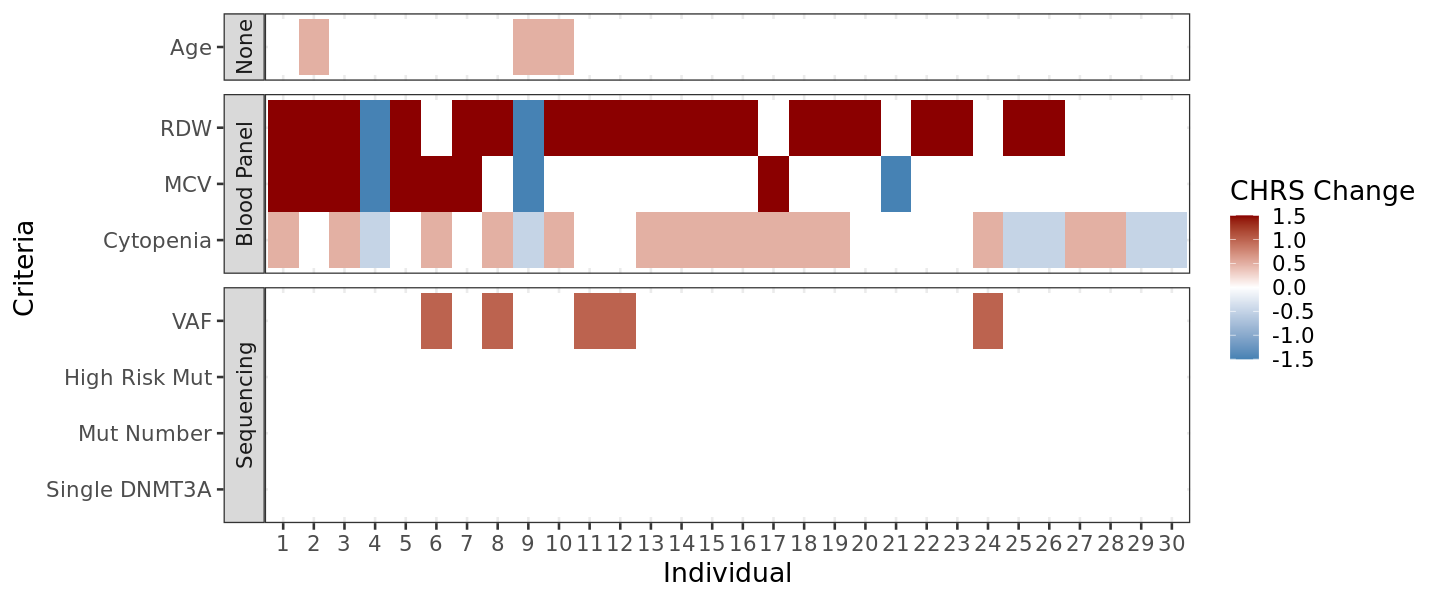

In [105]:
options(repr.plot.width=12, repr.plot.height=5) 

# people_order <- chrs_subset$fake_id[order(chrs_subset$RDW, decreasing = FALSE)]
# chrs_long$fake_id <- factor(chrs_long$fake_id, levels = people_order)

chrs_long$Test = factor(chrs_long$Test, levels=c('None','Blood Panel','Sequencing'))
chrs_long$variable <-factor(chrs_long$variable,levels=c("Single DNMT3A", "Mut Number", "High Risk Mut", "Age", "Cytopenia", "MCV", "VAF", "RDW"))
p<-ggplot(chrs_long, aes(x = fake_id, y = variable, fill = value)) + facet_grid(Test ~., scale="free_y", switch="y", space="free")+
geom_tile() +
scale_fill_gradient2(low = "steelblue", mid = "white", high = "red4") +
labs(x = "Individual", y = "Criteria", fill = "CHRS Change")+ theme_bw(base_size=16)
p
ggsave(p, filename = "CHRS_change_faceted.pdf",height = 5, width = 12)
system("gsutil cp CHRS_change_faceted.pdf gs://fc-fe5cdc03-3e69-4e53-a039-061947c78a43/files/MTP_figures/")